## Load data

In [1]:
import os
import json

def load_json_files(directory):
    cve_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), "r") as file:
                data = json.load(file)
                vulnerabilities = data.get("vulnerabilities", [])
                for vulnerability in vulnerabilities:
                    if vulnerability["cve"]["id"] not in cve_dict.keys():
                        cve_id = vulnerability["cve"]["id"]
                        cve_dict[cve_id] = vulnerability["cve"]
    return cve_dict

directory = "../2024_Data/NIST_2024"
cve_dictionary = load_json_files(directory)
print("Loaded {} CVEs into the dictionary.".format(len(cve_dictionary)))


Loaded 249088 CVEs into the dictionary.


In [73]:
import pandas as pd
import matplotlib.pyplot as plt

cves_not_in_xiaomi = pd.read_csv('../2024_Data/xiaomi/ASB_only_cves.csv')
cves_not_in_motorola = pd.read_csv('../2024_Data/motorola/ASB_only_cves.csv')
cves_not_in_oppo = pd.read_csv('../2024_Data/oppo/ASB_only_cves.csv')
cves_not_in_vivo = pd.read_csv('../2024_Data/vivo/ASB_only_cves.csv')
cves_not_in_huawei = pd.read_csv('../2024_Data/huawei/ASB_only_cves.csv')
cves_not_in_pixel = pd.read_csv('../2024_Data/pixel/ASB_only_cves.csv')
cves_not_in_lg = pd.read_csv('../2024_Data/lg/ASB_only_cves.csv')
cves_not_in_samsung = pd.read_csv('../2024_Data/samsung/missing_cves.csv')

## Functions for filtering out CVEs 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_cwe_severity_distribution(dataframe, OEM_name):
    top_cwes = dataframe['cwe'].value_counts().head(15)

    severity_data = []

    for cwe, count in top_cwes.items():
        severity_counts = dataframe[dataframe['cwe'] == cwe]['base_severity'].value_counts().reset_index()
        severity_counts.columns = ['severity', 'count']
        severity_counts['cwe'] = cwe
        severity_data.append(severity_counts)

    severity_df = pd.concat(severity_data, ignore_index=True)

    plt.figure(figsize=(8, 4))
    sns.barplot(x='cwe', y='count', hue='severity', data=severity_df)
    plt.title(f'Top 15 CWEs with Severity Distribution ({OEM_name})', fontsize=12)
    plt.xlabel('CWE', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend(title='Severity', loc='upper right', title_fontsize=10, fontsize=8)
    plt.tight_layout()

    # Extract cwe_info for CWEs in the chart
    unique_cwes = top_cwes.index
    cwe_info_texts = [f"Count: {dataframe['cwe'].value_counts()[cwe]} - {cwe}: {dataframe[dataframe['cwe'] == cwe]['cwe_info'].iloc[0]}" for cwe in unique_cwes]
    cwe_info_text = "\n".join(cwe_info_texts)

    # Add the cwe_info text at the bottom of the plot
    plt.gcf().text(0.02, -0.15, cwe_info_text, fontsize=10, ha='left', va='top')

    plt.savefig(f"../2024_Data/Figures/{OEM_name.lower()}_severity_distribution.png", bbox_inches="tight")

    plt.show()



In [6]:
import re

def extract_android_version(version_str):
    version_str = str(version_str)
    match = re.search(r'\d+(\.\d+)*', version_str)
    if match:
        return match.group(0)
    return None


In [7]:
import pandas as pd

def version_to_tuple(version):
    return tuple(map(int, version.split('.')))

def filter_cves_by_versions(missing_cves_df, df_groupby_year, vender):
    filtered_cves = []

    for cve in missing_cves_df['CVE']:
        cve_data = missing_cves_df[missing_cves_df['CVE'] == cve]

        if not cve_data.empty:
            year = cve_data['year'].iloc[0]
            month = cve_data['month'].iloc[0]
            device_data = df_groupby_year[(df_groupby_year['year'] == year) & (df_groupby_year['month'] == month)]
            if not device_data.empty:
                device_earliest_version = device_data['earliest_version'].iloc[0]
                device_latest_version = device_data['latest_version'].iloc[0]
                
                cve_earliest_version = cve_data['earliest_version'].iloc[0]
                cve_latest_version = cve_data['latest_version'].iloc[0]

                if pd.notna(cve_earliest_version) and pd.notna(device_earliest_version):
                    device_earliest_version_tuple = version_to_tuple(device_earliest_version)
                    cve_earliest_version_tuple = version_to_tuple(cve_earliest_version)

                    device_latest_version_tuple = version_to_tuple(device_latest_version)
                    cve_latest_version_tuple = version_to_tuple(cve_latest_version)

                    if cve_earliest_version_tuple > device_latest_version_tuple or  cve_latest_version_tuple < device_earliest_version_tuple:
                        # print(f"Skipping CVE {cve}:")
                        # if cve_earliest_version_tuple > device_latest_version_tuple:
                        #     print(f"cve_earliest_version_tuple: {cve_earliest_version_tuple} > device_latest_version_tuple: {device_latest_version_tuple}")
                        # if cve_latest_version_tuple < device_earliest_version_tuple:
                        #     print(f"cve_latest_version_tuple: {cve_latest_version_tuple} < device_earliest_version_tuple: {device_earliest_version_tuple}")
                        continue
                # else:
                #     print(f"Keeping CVE {cve}: CVE or device version is NaN")
                filtered_cves.append(cve)
            else:
                filtered_cves.append(cve)
        else:
            filtered_cves.append(cve)

    filtered_cves_df = missing_cves_df[missing_cves_df['CVE'].isin(filtered_cves)]
    output_file = f'../2024_Data/{vender.lower()}/filtered_missed_cves.csv'
    filtered_cves_df.to_csv(output_file, index=False)
    print('BEFORE:')
    print(f"Total records - {vender}: {len(missing_cves_df)}")
    print(f"Unique CVEs - {vender}: {len(set(missing_cves_df['CVE']))}")
    print('\nAFTER:')
    print(f"Total records - {vender}: {len(filtered_cves_df)}")
    print(f"Unique CVEs - {vender}: {len(set(filtered_cves_df['CVE']))}")

    return filtered_cves_df

In [8]:
import pandas as pd
import re

def extract_numeric_version(version):
    version = re.sub(r'[^\d.]', '', version)
    return version if version else None

def find_version_range(version_numbers):
    if pd.isna(version_numbers):
        return None, None
    versions = version_numbers.split(', ')
    numeric_versions = [extract_numeric_version(v) for v in versions]
    numeric_versions = [v for v in numeric_versions if v is not None]
    if not numeric_versions:
        return None, None
    numeric_versions.sort(key=lambda s: list(map(int, s.split('.'))))
    return numeric_versions[0], numeric_versions[-1]
    
def group_devices(df, vender):
    # Group by year and month, aggregate devices and android_versions into single columns
    grouped = df.groupby(['year', 'month']).agg({
        'device': lambda x: ', '.join(x.unique()),
        'android_version': lambda x: ', '.join(map(str, x.unique())),  # Convert values to strings
        'version_umbers': lambda x: ', '.join(str(num) for num in pd.Series(x).unique() if pd.notna(num)),
        'chipset': lambda x: ', '.join(map(str, x.unique())),
        'keyword': lambda x: ', '.join(x.unique())
    }).reset_index()
    version_ranges = grouped['version_umbers'].apply(find_version_range)
    grouped[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=grouped.index)

    return grouped

In [9]:
def print_security_updates_statistics(dataset, dataset_name):
    print(f'{dataset_name} Statistics:')
    print('Total records:', len(dataset))
    print('Unique devices:', len(set(dataset['device'])))


In [10]:
import re
import pandas as pd
from difflib import SequenceMatcher
from tqdm import tqdm
from fuzzywuzzy import fuzz
from collections import defaultdict
import re

def find_best_partial_match(device_name, device_list):
    best_match = None
    max_similarity = 0
    
    words = device_name.lower().split()
    
    for i in range(len(words)):
        current_word = words[i]
        
        # Filter device_list based on previous matches to ensure prioritization
        if i == 0:
            filtered_devices = [device for device in device_list if current_word in device.lower().split()]
        else:
            filtered_devices = [device for device in filtered_devices if current_word in device.lower().split()]
        
        # If filtered list is empty, break the loop
        if not filtered_devices:
            break
        
        # Calculate similarity for each device in filtered list
        for device in filtered_devices:
            similarity = fuzz.partial_ratio(device_name, device)
            
            # Check numeric comparison to avoid smaller numbers matching larger ones
            if any(word.isdigit() for word in words):
                main_number = re.search(r'\d+', device_name).group() if re.search(r'\d+', device_name) else ''
                dev_number = re.search(r'\d+', device).group() if re.search(r'\d+', device) else ''
                
                if main_number and dev_number and int(main_number) < int(dev_number):
                    continue
            
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = device
    # print(f"Best match for '{device_name}' is '{best_match}'.")
    return best_match


# Function to clean device names and create mappings
def map_chipsets(phone_data, oem_device_data):
    phone_data['device'] = phone_data['device'].str.strip().str.lower()
    oem_device_data['device'] = oem_device_data['device'].str.strip().str.lower()

    # Create the mapping from device to chipset
    device_to_chipset = dict(zip(phone_data['device'], phone_data['Chipset']))
    oem_device_data['chipset'] = oem_device_data['device'].map(device_to_chipset)

    missing_chipsets = oem_device_data[oem_device_data['chipset'].isna()]
    
    # Identify and update missing mappings with partial matches
    for idx, row in tqdm(missing_chipsets.iterrows(), total=len(missing_chipsets), desc="Mapping chipsets"):
        partial_match = find_best_partial_match(row['device'], phone_data['device'])
        if partial_match is not None:
            oem_device_data.at[idx, 'chipset'] = device_to_chipset[partial_match]
    
    # Function to split chipset if it contains both 'Qualcomm' and 'Snapdragon'
    def split_chipsets(chipset):
        if isinstance(chipset, str) and 'Qualcomm' in chipset and 'Snapdragon' in chipset:
            qualcomm_part, snapdragon_part = chipset.split(' Snapdragon ', 1)
            
            qualcomm_part = qualcomm_part.strip()
            snapdragon_part = snapdragon_part.strip()
            
            if len(qualcomm_part.split()) <= 1 and len(snapdragon_part.split()) > 1:
                return f'Snapdragon {snapdragon_part.strip()}'
            elif len(qualcomm_part.split()) > 1 and len(snapdragon_part.split()) <= 1:
                return qualcomm_part.strip()
            else:
                return ','.join([qualcomm_part.strip(), f'Snapdragon {snapdragon_part.strip()}'])
        else:
            return chipset
            
    # Splitting the 'chipset' column by newline and then by hyphen ('-')
    def split_and_clean_chipset(chipsets, area):
        if isinstance(chipsets, str):
            parts = chipsets.split('\n')
            for part in parts:
                if '-' in part:
                    chipset, region = part.split('-', 1)
                    chipset = chipset.strip()
                    region = region.strip()
                    if region in area:
                        parts.remove(part)
                        if 'Qualcomm' in chipset and 'Snapdragon' in chipset:
                            chipset = split_chipsets(chipset)
                        return chipset
                    elif region == 'Global' or region == 'International' or region == 'ROW':
                        parts.remove(part)
                        if 'Qualcomm' in chipset and 'Snapdragon' in chipset:
                            chipset = split_chipsets(chipset)
                        return chipset
                        
            cleaned_parts = [part.split('-', 1)[0].strip() for part in parts]
            cleaned_parts = [split_chipsets(part) if 'Qualcomm' in part and 'Snapdragon' in part else part for part in cleaned_parts]
            return ', '.join([item if isinstance(item, str) else ' '.join(item) for item in cleaned_parts])
        return chipsets
    
    # oem_device_data['chipset'] = oem_device_data['chipset'].apply(split_and_clean_chipset)
    if 'region' in oem_device_data.columns:
        for i, row in oem_device_data.iterrows():
            region = row['region']
            area = region
            if 'country' in oem_device_data.columns:
                country = row['country']
                area = f"{region}/{country}"
            cleaned_chipset = split_and_clean_chipset(row['chipset'], area)
            oem_device_data.at[i, 'chipset'] = cleaned_chipset

    # Clean the 'keyword' for entries containing "Exynos"
    def clean_exynos(keyword):
        if "Exynos" in keyword:
            match = re.search(r"(Exynos)\s*\w*\s*(\d{4})", keyword)
            if match:
                return f"{match.group(1)} {match.group(2)}"
        return keyword
        
    def create_keyword(chipset):
        if isinstance(chipset, str):
            keywords = ','.join([re.split(r'\s*[/()]\s*', clean_exynos(item))[0].strip().lower() for item in chipset.split(',')])
            return keywords
        return ''

    oem_device_data['keyword'] = oem_device_data['chipset'].apply(create_keyword)
    
    remaining_missing = oem_device_data[oem_device_data['chipset'].isnull()]
    print("Devices with missing chipset:")
    print(remaining_missing['device'].unique())

    return oem_device_data


In [11]:
import pandas as pd

def filter_cves_by_chipsets(missing_cves_df, df_groupby_year, vender, cve_dictionary):
    filtered_cves = []
    chipsets = ['qualcomm', 'snapdragon', 'mediatek', 'exynos', 'hisilicon', 'kirin', 'unisoc', 
                'nvidia', 'tegra', 'tensor', 'intel', 'atom', 'hummingbird']
    
    for cve in missing_cves_df['CVE']:
        cve_data = missing_cves_df[missing_cves_df['CVE'] == cve]

        if not cve_data.empty:
            year = cve_data['year'].iloc[0]
            month = cve_data['month'].iloc[0]
            device_data = df_groupby_year[(df_groupby_year['year'] == year) & (df_groupby_year['month'] == month)]
            
            if not device_data.empty:
                device_chipsets = device_data['keyword'].iloc[0]
                
                # Determine the chipset associated with the CVE
                cve_chipset = None
                for chipset in chipsets:
                    if any(chipset in str(value).lower() for value in cve_dictionary.get(cve, {}).values()):
                        cve_chipset = chipset
                        break
                
                # Check if device_chipsets and cve_chipset are not None and perform comparison
                if cve_chipset and pd.notna(device_chipsets):
                    if cve_chipset not in device_chipsets.lower():
                        # print(f"cve_chipset: {cve_chipset} NOT IN device_chipsets: {device_chipsets}")
                        continue
                
                filtered_cves.append(cve)
            else:
                filtered_cves.append(cve)
        else:
            filtered_cves.append(cve)

    filtered_cves_df = missing_cves_df[missing_cves_df['CVE'].isin(filtered_cves)]
    output_file = f'../2024_Data/{vender.lower()}/filtered_missed_cves.csv'
    filtered_cves_df.to_csv(output_file, index=False)
    
    print('BEFORE:')
    print(f"Total records - {vender}: {len(missing_cves_df)}")
    print(f"Unique CVEs - {vender}: {len(set(missing_cves_df['CVE']))}")
    print('\nAFTER:')
    print(f"Total records - {vender}: {len(filtered_cves_df)}")
    print(f"Unique CVEs - {vender}: {len(set(filtered_cves_df['CVE']))}")

    return filtered_cves_df


In [12]:
import re
from tqdm import tqdm

def map_versions(phone_data, oem_device_data):
    phone_data['device'] = phone_data['device'].str.strip().str.lower()
    oem_device_data['device'] = oem_device_data['device'].str.strip().str.lower()
    oem_device_data['android_version'] = oem_device_data['android_version'].astype(str)
    
    def extract_final_android_version(os_string):
        android_versions = re.findall(r'Android \d+\.?\d*', os_string)
        if android_versions:
            return android_versions[-1]
        return None
    
    phone_data['final_android_version'] = phone_data['OS'].apply(extract_final_android_version)
    device_to_version = dict(zip(phone_data['device'], phone_data['final_android_version']))
    oem_device_data['android_version'] = oem_device_data.apply(lambda row: device_to_version.get(row['device'], row['android_version']), axis=1)
    missing_versions = oem_device_data[
        oem_device_data['android_version'].isna() | 
        (oem_device_data['android_version'].str.strip().str.lower() == 'nan')
    ]
    for idx, row in tqdm(missing_versions.iterrows(), total=len(missing_versions), desc="Mapping versions"):
        partial_match = find_best_partial_match(row['device'], phone_data['device'])
        if partial_match is not None:
            oem_device_data.at[idx, 'android_version'] = device_to_version[partial_match]
    
    remaining_missing = oem_device_data[oem_device_data['android_version'].isnull()]
    print("Devices with missing android_version:")
    print(remaining_missing['device'].unique())
    
    return oem_device_data

In [13]:
def process_versions(version):
    if isinstance(version, str):
        parts = version.split()
        if len(parts) == 2 and len(parts[1].split('.')) == 1:
            return parts[0] + " " + parts[1] + ".0"
        else:
            return version
    else:
        return version

## Samsung

In [14]:
samsung_support_list = pd.read_csv('../2024_Data/samsung/combined_support_lists.csv')
samsung_security_updates = pd.read_csv('../2024_Data/samsung/samsung_security_updates_combined.csv')

print('Unique devices in support lists', len(set(samsung_support_list['device'])))
print_security_updates_statistics(samsung_security_updates, 'Samsung')

Unique devices in support lists 340
Samsung Statistics:
Total records: 528251
Unique devices: 423


In [15]:
samsung_security_updates['release_date'] = pd.to_datetime(samsung_security_updates['release_date'], format='%m/%d/%y', errors='coerce')
samsung_security_updates['year'] = samsung_security_updates['release_date'].dt.year
samsung_security_updates['month'] = samsung_security_updates['release_date'].dt.month

samsung_security_updates['version_umbers'] = samsung_security_updates['android_version'].apply(extract_android_version)
samsung_security_updates.head()

,model,csc,csc_code,device_id,carrier_country,country,carrier,region,subregion,build_number,android_version,release_date,security_patch_level,device,model_url,year,month,version_umbers
0,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fwc2,s(android 12),2023-04-11,2/1/23,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2023,4,12
1,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fwa1,s(android 12),2023-01-18,12/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2023,1,12
2,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvj7,s(android 12),2022-11-16,9/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,11,12
3,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvj3,s(android 12),2022-10-27,6/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,10,12
4,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvf5,s(android 12),2022-07-07,4/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,7,12


In [16]:
samsung_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='samsung')

replacements = [
    ('samsung', ''),
    ('"', ''),
    ('-', ' '),
    ('galaxy tab a,', ''),
    (',galaxy tab a', ''),
    ('sm-n975f,', ''),
    (',sm-n975f', ''),
    ('galaxy tab s2,', ''),
    ('galaxy tab a‚ë• with s pen,', ''),
    ('‚ë• with s pen', 'with s pen'),
    ('‚ë•', ''),
    ('w/ s pen', 'with s pen'), 
    ('with s pen with s pen', 'with s pen')
]

# Function to clean device names
def clean_device_name(name):
    for old, new in replacements:
        name = name.replace(old, new)
    name = 'galaxy ' + name if 'watch' in name else name
    name = name.split(',')[0] if ',' in name else name
    return name.strip()

samsung_security_updates['device'] = samsung_security_updates['device'].apply(clean_device_name)
samsung_security_updates.loc[samsung_security_updates['device'] == 'sm e346b', 'device'] = 'Galaxy F34 5G'

samsung_security_updates = map_chipsets(samsung_phone_data, samsung_security_updates)

import re

device_mappings = {
    'w20 5g': ('Qualcomm SDM855 Snapdragon 855+ (7 nm)', 'Qualcomm SDM855,Snapdragon 855+'),
    'w2016': ('Exynos 7 Octa 7420 (14 nm)', 'Exynos 7420'),
    'w2017': ('Qualcomm Snapdragon 820', 'Snapdragon 820'),
    'w2018': ('Qualcomm Snapdragon 835', 'Snapdragon 835'),
    'w2019': ('Qualcomm Snapdragon 845', 'Snapdragon 845'),
    'w21 5g': ('Qualcomm Snapdragon 865+', 'Snapdragon 865+'),
    'w22 5g': ('Qualcomm Snapdragon 888 (SM8350)', 'Qualcomm SM8350,Snapdragon 888'),
    'w23': ('Qualcomm Snapdragon 8+ Gen 1 (SM8475)', 'Qualcomm SM8475,Snapdragon 8+ Gen 1'),
    'w23 flip': ('Qualcomm Snapdragon 8+ Gen 1 (SM8475)', 'Qualcomm SM8475,Snapdragon 8+ Gen 1'),
    'w24': ('Qualcomm Snapdragon 8 Gen 2', 'Snapdragon 8 Gen 2'),
    'w24 flip': ('Qualcomm Snapdragon 8 Gen 2', 'Snapdragon 8 Gen 2'),
    'g9298': ('Qualcomm Snapdragon 821AB', 'Snapdragon 821AB'),
    'galaxy a6': ('Exynos 7870 Octa (14 nm)', 'Exynos 7870'),
    'galaxy a9': {
        lambda row: int(re.search(r'\d+', row['android_version']).group()) > 5: ('Qualcomm SDM660 Snapdragon 660 (14 nm)', 'Qualcomm SDM660,Snapdragon 660'),
        lambda row: int(re.search(r'\d+', row['android_version']).group()) <= 5: ('Qualcomm MSM8976 Snapdragon 652 (28 nm)', 'Qualcomm MSM8976,Snapdragon 652')
    },
    'galaxy c8': ('MediaTek Helio P20 (MT6757)', 'MediaTek MT6757'),
    'galaxy folder 2 dual sim': ('Snapdragon 425', 'Snapdragon 425'),
    'galaxy j3 pop': {
        lambda row: int(re.search(r'\d+', row['android_version']).group()) > 6: ('Exynos 7570 Quad (14 nm)', 'Exynos 7570'),
        lambda row: int(re.search(r'\d+', row['android_version']).group()) <= 6 and row['country'] == 'USA': ('Exynos 3475 Quad (28 nm) - USA', 'Exynos 3475'),
        lambda row: int(re.search(r'\d+', row['android_version']).group()) <= 6: ('Spreadtrum SC9830', 'Spreadtrum SC9830')
    },
    'galaxy tab a 88': ('Unisoc Tiger T618 (12 nm)', 'Unisoc T618'),
    'galaxy tab s': ('Unisoc Tiger T618 (12 nm)', 'Unisoc T618'),
    'galaxy tab a 9.7 with s pen': ('Qualcomm Snapdragon 410', 'Snapdragon 410'),
    'galaxy tab a 9.7': ('Qualcomm Snapdragon 410', 'Snapdragon 410'),
    'galaxy tab active5': ('Exynos 1380', 'exynos 1380'),
    'galaxy tab active5 5g': ('Exynos 1380', 'exynos 1380'),
    'galaxy a14 5g': ('Mediatek MT6833 Dimensity 700', 'mediatek mt6833'),
    'galaxy tab s6 lite': {
        lambda row: int(re.search(r'\d+', row['android_version']).group()) > 10: ('Qualcomm SM7150 Snapdragon 732G', 'Qualcomm SM7150,Snapdragon 732G'),
        lambda row: int(re.search(r'\d+', row['android_version']).group()) <= 10: ('Exynos 9611 (10 nm)', 'Exynos 9611')
    },
    'galaxy tab s2 8.0': {
        lambda row: row['country'] == 'USA': ('Exynos 5433', 'Exynos 5433'),
        lambda row: True: ('Qualcomm MSM8976,Snapdragon 652 (28 nm)', 'qualcomm msm8976,snapdragon 652')
    },
    'galaxy a5 (2016)': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8939 Snapdragon 615', 'Qualcomm MSM8939,Snapdragon 615'),
        lambda row: True: ('Exynos 7580 Octa (28 nm)', 'exynos 7580')
    },
    'galaxy a5 (2016)': {
        lambda row: row['region'] == 'Europe': ('Exynos 1330 (5 nm)', 'exynos 1330'),
        lambda row: True: ('MediaTek Dimensity 700 (7 nm)', 'mediatek dimensity 700')
    },
    'galaxy note8': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm Snapdragon 835 (MSM8998)', 'qualcomm msm8998,snapdragon 835'),
        lambda row: True: ('Exynos 8895 (10 nm)', 'exynos 8895')
    },
    'galaxy note9': {
        lambda row: row['country'] == 'USA': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9820 (8 nm)', 'exynos 9820')
    },
    'galaxy note10': {
        lambda row: row['country'] == 'USA': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9820 (8 nm)', 'exynos 9820')
    },
    'galaxy s20': {
        lambda row: row['region'] == 'Europe': ('Exynos 990 (7 nm+)', 'exynos 990'),
        lambda row: True: ('Qualcomm sm8250 Snapdragon 865', 'qualcomm sm8250,snapdragon 865')
    },
    'galaxy tab s2 9.7': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8976,Snapdragon 652 (28 nm)', 'qualcomm msm8976,snapdragon 652'),
        lambda row: True: ('Exynos 5433', 'exynos 5433')
    },
    'galaxy a3 (2016)': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8916,Snapdragon 410 (28 nm)', 'qualcomm msm8916,snapdragon 410'),
        lambda row: True: ('Exynos 7578', 'exynos 7578')
    },
    'galaxy a7 (2016)': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8939,Snapdragon 615 (28 nm)', 'qualcomm msm8939,snapdragon 615'),
        lambda row: True: ('Exynos 7580 Octa (28 nm)', 'exynos 7580')
    },
    'galaxy s8': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8998,Snapdragon 835 (10 nm)', 'qualcomm msm8998,snapdragon 835'),
        lambda row: True: ('Exynos 8895 (10 nm)', 'exynos 8895')
    },
    'galaxy s8+': {
        lambda row: row['country'] == 'USA': ('Qualcomm MSM8998,Snapdragon 835 (10 nm)', 'qualcomm msm8998,snapdragon 835'),
        lambda row: True: ('Exynos 8895 (10 nm)', 'exynos 8895')
    },
    'galaxy s9': {
        lambda row: row['country'] == 'USA': ('Qualcomm SDM845,Snapdragon 845 (10 nm)', 'qualcomm sdm845,snapdragon 845'),
        lambda row: True: ('Exynos 9810 (10 nm)', 'exynos 9810')
    },
    'galaxy s9+': {
        lambda row: row['country'] == 'USA': ('Qualcomm SDM845,Snapdragon 845 (10 nm)', 'qualcomm sdm845,snapdragon 845'),
        lambda row: True: ('Exynos 9810 (10 nm)', 'exynos 9810')
    },
    'galaxy s10': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9820 (8 nm)', 'exynos 9820')
    },
    'galaxy s10+': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9820 (8 nm)', 'exynos 9820')
    },
    'galaxy s10e': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9820 (8 nm)', 'exynos 9820')
    },
    'galaxy note10 5g': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150 Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9825 (7 nm)', 'exynos 9825')
    },
    'galaxy note10+': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9825 (7 nm)', 'exynos 9825')
    },
    'galaxy note10+ 5g': {
        lambda row: row['country'] == 'USA' or row['country'] == 'China': ('Qualcomm SM8150,Snapdragon 855 (7 nm)', 'qualcomm sm8150,snapdragon 855'),
        lambda row: True: ('Exynos 9825 (7 nm)', 'exynos 9825')
    },
    'galaxy s20 fe': {
        lambda row: row['country'] == 'USA': ('Qualcomm SM8250,Snapdragon 865 5G (7 nm+)', 'qualcomm sm8250,snapdragon 865 5g'),
        lambda row: True: ('Exynos 990 (7 nm+)', 'exynos 990')
    },
    'galaxy s20 ultra': {
        lambda row: row['country'] == 'USA': ('Qualcomm SM8250,Snapdragon 865 5G (7 nm+)', 'qualcomm sm8250,snapdragon 865 5g'),
        lambda row: True: ('Exynos 990 (7 nm+)', 'exynos 990')
    },
    'galaxy j3 (2016)': {
        lambda row: row['country'] == 'USA': ('Spreadtrum SC9830', 'spreadtrum sc9830'),
        lambda row: True: ('Exynos 3475 Quad (28 nm)', 'exynos 3475')
    }
}

for i, row in samsung_security_updates.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):  # Direct mapping
            samsung_security_updates.at[i, 'chipset'], samsung_security_updates.at[i, 'keyword'] = mapping
        elif isinstance(mapping, dict):  # Conditional mapping
            for condition, (chipset, keyword) in mapping.items():
                if condition(row):
                    samsung_security_updates.at[i, 'chipset'], samsung_security_updates.at[i, 'keyword'] = chipset, keyword
                    break

samsung_security_updates['keyword'] = samsung_security_updates['keyword'].str.lower()

def keep_mediatek_and_next(keyword):
    if isinstance(keyword, str):
        match = re.match(r"(mediatek \S+)", keyword)
        return match.group(1) if match else keyword
    return keyword

samsung_security_updates['keyword'] = samsung_security_updates['keyword'].apply(lambda x: ','.join([keep_mediatek_and_next(keyword) for keyword in str(x).split(',')]))
samsung_security_updates.head()

Mapping chipsets: 100%|██████████████████| 87138/87138 [04:25<00:00, 328.70it/s]


Devices with missing chipset:
['w20 5g' 'w2019' 'w21 5g' 'w22 5g' 'w23' 'w23 flip' 'w24' 'w24 flip'
 'g9298' 'galaxy tab a 9.7' 'galaxy tab a 9.7 with s pen' 'galaxy tab s'
 'galaxy tab s6 lite' 'sm n975f' 'smasung galaxy note10+5g' 'w2016'
 'w2017' 'w2018']


,model,csc,csc_code,device_id,carrier_country,country,carrier,region,subregion,build_number,android_version,release_date,security_patch_level,device,model_url,year,month,version_umbers,chipset,keyword
0,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fwc2,s(android 12),2023-04-11,2/1/23,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2023,4,12,Qualcomm SDM855 Snapdragon 855+ (7 nm),"qualcomm sdm855,snapdragon 855+"
1,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fwa1,s(android 12),2023-01-18,12/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2023,1,12,Qualcomm SDM855 Snapdragon 855+ (7 nm),"qualcomm sdm855,snapdragon 855+"
2,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvj7,s(android 12),2022-11-16,9/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,11,12,Qualcomm SDM855 Snapdragon 855+ (7 nm),"qualcomm sdm855,snapdragon 855+"
3,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvj3,s(android 12),2022-10-27,6/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,10,12,Qualcomm SDM855 Snapdragon 855+ (7 nm),"qualcomm sdm855,snapdragon 855+"
4,sm-w2020,CHC,10328191220,sm-w2020/chc,China (Open China),China,Open China,Asia,Eastern Asia,w2020zcu3fvf5,s(android 12),2022-07-07,4/1/22,w20 5g,https://doc.samsungmobile.com/SM-W2020/0103281...,2022,7,12,Qualcomm SDM855 Snapdragon 855+ (7 nm),"qualcomm sdm855,snapdragon 855+"


In [17]:
samsung_groupby_date = group_devices(samsung_security_updates, 'samsung')
samsung_groupby_date.head()

,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2015,4,"galaxy s6, galaxy s6 edge",lollipop(android 5.0.2),5.0.2,Exynos 7420 Octa (14 nm),exynos 7420,5.0.2,5.0.2
1,2015,5,"galaxy s6, galaxy s6 edge, galaxy tab a 8 with...",lollipop(android 5.0.2),5.0.2,"Exynos 7420 Octa (14 nm), Spreadtrum SC8830","exynos 7420, spreadtrum sc8830",5.0.2,5.0.2
2,2015,6,"galaxy j5 (2015), galaxy s6, galaxy s6 edge, g...","lollipop(android 5.1), lollipop(android 5.0.2)","5.1, 5.0.2","Qualcomm MSM8916,Snapdragon 410 (28 nm), Exyno...","qualcomm msm8916,snapdragon 410, exynos 7420, ...",5.0.2,5.1
3,2015,7,"galaxy a8 (2015), galaxy s6, galaxy s6 edge",lollipop(android 5.1.1),5.1.1,"Qualcomm MSM8939,Snapdragon 615 (28 nm), Exyno...","qualcomm msm8939,snapdragon 615, exynos 7420",5.1.1,5.1.1
4,2015,8,"galaxy a8 (2015), galaxy j5 (2015), galaxy j7 ...","lollipop(android 5.1.1), lollipop(android 5.1)...","5.1.1, 5.1, 5.0.2","Qualcomm MSM8939,Snapdragon 615 (28 nm), Qualc...","qualcomm msm8939,snapdragon 615, qualcomm msm8...",5.0.2,5.1.1


In [18]:
print(len(set(cves_not_in_samsung['CVE'])))

version_ranges = cves_not_in_samsung['vul_true'].apply(find_version_range)
cves_not_in_samsung[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_samsung.index)
cves_not_in_samsung[~cves_not_in_samsung['earliest_version'].isnull()].head()

80


,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
0,2497,CVE-2023-40106,2023,11,11/1/23,NaN,A-278558814,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-01,11,14
1,2498,CVE-2023-40107,2023,11,11/1/23,NaN,A-287298721,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-01,12,14
2,2499,CVE-2023-40109,2023,11,11/1/23,NaN,A-291299076,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-01,11,14
3,2500,CVE-2023-40110,2023,11,11/1/23,NaN,A-243463593,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-01,11,14
4,2501,CVE-2023-40111,2023,11,11/1/23,NaN,A-272024837,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-01,14,14


In [19]:
samsung_missing_cves = filter_cves_by_versions(cves_not_in_samsung, samsung_groupby_date, "Samsung")

BEFORE:
Total records - Samsung: 105
Unique CVEs - Samsung: 80

AFTER:
Total records - Samsung: 101
Unique CVEs - Samsung: 77


In [20]:
samsung_missing_cves_final = filter_cves_by_chipsets(samsung_missing_cves, samsung_groupby_date, 'Samsung', cve_dictionary)

BEFORE:
Total records - Samsung: 101
Unique CVEs - Samsung: 77

AFTER:
Total records - Samsung: 99
Unique CVEs - Samsung: 75


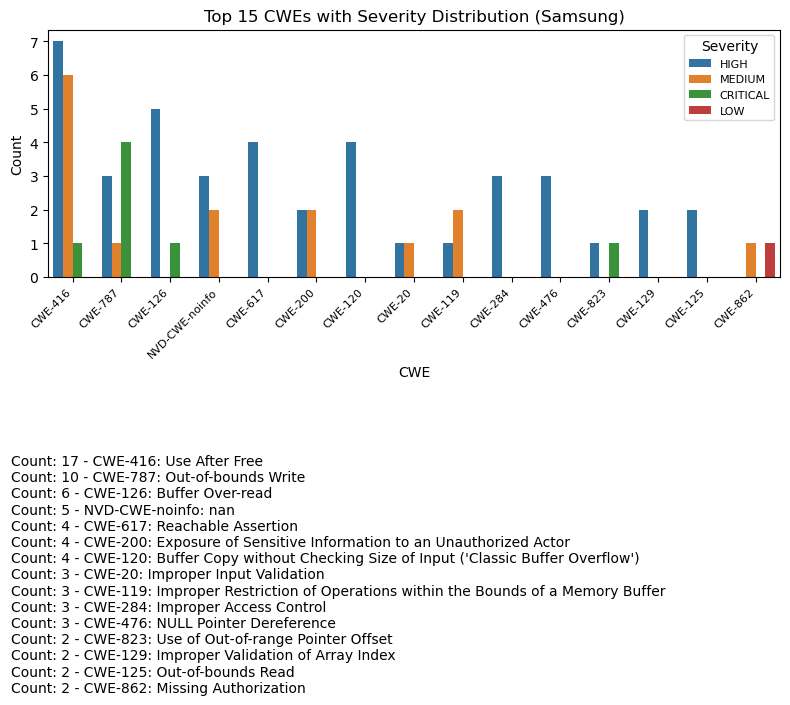

In [21]:
plot_cwe_severity_distribution(samsung_missing_cves_final, "Samsung")

In [22]:
cve_counts_by_year = samsung_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = samsung_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = samsung_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = samsung_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = samsung_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = samsung_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

year
2023    63
2024    19
2017     9
2020     3
2019     2
2022     2
2018     1
Name: count, dtype: int64

base_severity
HIGH        49
MEDIUM      19
CRITICAL     8
LOW          1
Name: count, dtype: int64

component
Closed-source component    35
Mali                       11
Audio                       4
Display                     3
Kernel                      2
Name: count, dtype: int64

attack_vector
LOCAL       44
NETWORK     32
PHYSICAL     1
Name: count, dtype: int64

user_interaction
NONE        75
REQUIRED     2
Name: count, dtype: int64

attack_complexity
LOW     71
HIGH     6
Name: count, dtype: int64


## Xiaomi

In [23]:
xiaomi_security_updates = pd.read_csv('../2024_Data/xiaomi/xiaomi_security_updates_combined.csv')

print_security_updates_statistics(xiaomi_security_updates, 'Xiaomi')

Xiaomi Statistics:
Total records: 4933
Unique devices: 328


In [24]:
xiaomi_security_updates.rename(columns={'date': 'release_date', 'android': 'android_version'}, inplace=True)
xiaomi_security_updates.head()

,android_version,branch,codename,release_date,link,md5,method,name,size,version,device,region,codename_short,changelog_url,changelog,SPL,SPL_date,delay,delay_days,device_type
0,14.0,Stable Beta,air_global,6/21/24,https://bigota.d.miui.com/OS1.0.2.0.UGQMIXM/mi...,3a209a95cf459cb3627064a04d838719,Recovery,Redmi 13R 5G / 13C 5G Global,4.4 GB,OS1.0.2.0.UGQMIXM,Redmi 13R 5G / 13C 5G,Global,air,https://xiaomifirmwareupdater.com/miui/air/sta...,NaN,NaN,NaN,NaN,NaN,Phone
1,13.0,Stable Beta,pissarro_in_fk_global,6/21/24,https://bigota.d.miui.com/OS1.0.4.0.TKTINFK/mi...,4db2a59340c910897a8364aa3cae8684,Recovery,Xiaomi 11i 5G India,3.7 GB,OS1.0.4.0.TKTINFK,Xiaomi 11i 5G,India,pissarro,https://xiaomifirmwareupdater.com/miui/pissarr...,NaN,NaN,NaN,NaN,NaN,Phone
2,14.0,Stable,ruan_in_global,6/21/24,https://bigota.d.miui.com/OS1.0.1.0.UFSINXM/mi...,42dad36ffb4679828590feedf802bed4,Recovery,Redmi Pad Pro 5G / POCO Pad 5G India,4.2 GB,OS1.0.1.0.UFSINXM,Redmi Pad Pro 5G / POCO Pad 5G,India,ruan,https://xiaomifirmwareupdater.com/miui/ruan/st...,NaN,NaN,NaN,NaN,NaN,Tablet
3,14.0,Stable Beta,vermeer_ru_global,6/21/24,https://bigota.d.miui.com/OS1.0.3.0.UNKRUXM/mi...,4ba449360797c3cfb500a7163e562982,Recovery,POCO F6 Pro Russia,6.3 GB,OS1.0.3.0.UNKRUXM,POCO F6 Pro,Russia,vermeer,https://xiaomifirmwareupdater.com/miui/vermeer...,NaN,NaN,NaN,NaN,NaN,Phone
4,14.0,Stable Beta,moon_eea_global,6/20/24,https://bigota.d.miui.com/OS1.0.3.0.UNTEUXM/mi...,b44caa78930161287e5c0c49a1d054fb,Recovery,Redmi 13 / POCO M6 EEA,4.5 GB,OS1.0.3.0.UNTEUXM,Redmi 13 / POCO M6,EEA,moon,https://xiaomifirmwareupdater.com/miui/moon/st...,NaN,NaN,NaN,NaN,NaN,Phone


In [25]:
xiaomi_security_updates['release_date'] = pd.to_datetime(xiaomi_security_updates['release_date'], errors='coerce')

xiaomi_security_updates['year'] = xiaomi_security_updates['release_date'].dt.year
xiaomi_security_updates['month'] = xiaomi_security_updates['release_date'].dt.month
xiaomi_security_updates['version_umbers'] = xiaomi_security_updates['android_version'].apply(extract_android_version)
xiaomi_security_updates.head()

/var/folders/64/c68452391mv_849dpqtr2rch0000gn/T/ipykernel_1286/3129319563.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  xiaomi_security_updates['release_date'] = pd.to_datetime(xiaomi_security_updates['release_date'], errors='coerce')


,android_version,branch,codename,release_date,link,md5,method,name,size,version,...,changelog_url,changelog,SPL,SPL_date,delay,delay_days,device_type,year,month,version_umbers
0,14.0,Stable Beta,air_global,2024-06-21,https://bigota.d.miui.com/OS1.0.2.0.UGQMIXM/mi...,3a209a95cf459cb3627064a04d838719,Recovery,Redmi 13R 5G / 13C 5G Global,4.4 GB,OS1.0.2.0.UGQMIXM,...,https://xiaomifirmwareupdater.com/miui/air/sta...,NaN,NaN,NaN,NaN,NaN,Phone,2024,6,14.0
1,13.0,Stable Beta,pissarro_in_fk_global,2024-06-21,https://bigota.d.miui.com/OS1.0.4.0.TKTINFK/mi...,4db2a59340c910897a8364aa3cae8684,Recovery,Xiaomi 11i 5G India,3.7 GB,OS1.0.4.0.TKTINFK,...,https://xiaomifirmwareupdater.com/miui/pissarr...,NaN,NaN,NaN,NaN,NaN,Phone,2024,6,13.0
2,14.0,Stable,ruan_in_global,2024-06-21,https://bigota.d.miui.com/OS1.0.1.0.UFSINXM/mi...,42dad36ffb4679828590feedf802bed4,Recovery,Redmi Pad Pro 5G / POCO Pad 5G India,4.2 GB,OS1.0.1.0.UFSINXM,...,https://xiaomifirmwareupdater.com/miui/ruan/st...,NaN,NaN,NaN,NaN,NaN,Tablet,2024,6,14.0
3,14.0,Stable Beta,vermeer_ru_global,2024-06-21,https://bigota.d.miui.com/OS1.0.3.0.UNKRUXM/mi...,4ba449360797c3cfb500a7163e562982,Recovery,POCO F6 Pro Russia,6.3 GB,OS1.0.3.0.UNKRUXM,...,https://xiaomifirmwareupdater.com/miui/vermeer...,NaN,NaN,NaN,NaN,NaN,Phone,2024,6,14.0
4,14.0,Stable Beta,moon_eea_global,2024-06-20,https://bigota.d.miui.com/OS1.0.3.0.UNTEUXM/mi...,b44caa78930161287e5c0c49a1d054fb,Recovery,Redmi 13 / POCO M6 EEA,4.5 GB,OS1.0.3.0.UNTEUXM,...,https://xiaomifirmwareupdater.com/miui/moon/st...,NaN,NaN,NaN,NaN,NaN,Phone,2024,6,14.0


In [26]:
xiaomi_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='xiaomi')

xiaomi_phone_data = xiaomi_phone_data.rename(columns={'Name': 'device'})
xiaomi_security_updates['device'] = xiaomi_security_updates['device'].astype(str)
xiaomi_security_updates['device'] = xiaomi_security_updates['device'].str.replace('xiaomi', '')
xiaomi_security_updates['device'] = xiaomi_security_updates['device'].apply(lambda x: 'mi pad' if 'mipad' in x.lower() else x)

xiaomi_with_chipsets = map_chipsets(xiaomi_phone_data, xiaomi_security_updates)
xiaomi_with_chipsets.head()

Mapping chipsets: 100%|███████████████████| 2251/2251 [00:01<00:00, 1415.41it/s]


Devices with missing chipset:
['xiaomi 11i 5g' 'xiaomi 13 pro' 'xiaomi 12 pro dimensity' 'xiaomi 14'
 'xiaomi pad 6 max 14' 'xiaomi 13' 'xiaomi civi 4 pro'
 'xiaomi pad 6s pro 12.4' 'xiaomi civi 2' 'xiaomi 11t' 'xiaomi 14 ultra'
 'xiaomi mix fold 2' 'xiaomi pad 6' 'xiaomi 12t pro' 'xiaomi 12 lite'
 'xiaomi 13 lite' 'xiaomi civi 2 / 13 lite' 'xiaomi 12' 'xiaomi pad 5'
 'xiaomi pad 5 pro 12.4' 'xiaomi 12 pro' 'xiaomi 13t'
 'xiaomi pad 5 pro wi-fi' 'xiaomi pad 5 pro 5g' 'xiaomi 12t'
 'xiaomi 11t pro' 'xiaomi 12x' 'xiaomi 13 ultra' 'xiaomi 14 pro / ti'
 'xiaomi civi 1s' 'xiaomi 13t pro' 'xiaomi 11 lite 5g ne'
 'xiaomi 12s ultra' 'xiaomi 12s pro' 'xiaomi pad 6 pro' 'xiaomi 12s'
 'xiaomi civi 3' 'xiaomi 11i / hypercharge' 'xiaomi 14 pro ti satellite'
 'xiaomi civi']


,android_version,branch,codename,release_date,link,md5,method,name,size,version,...,SPL,SPL_date,delay,delay_days,device_type,year,month,version_umbers,chipset,keyword
0,14.0,Stable Beta,air_global,2024-06-21,https://bigota.d.miui.com/OS1.0.2.0.UGQMIXM/mi...,3a209a95cf459cb3627064a04d838719,Recovery,Redmi 13R 5G / 13C 5G Global,4.4 GB,OS1.0.2.0.UGQMIXM,...,NaN,NaN,NaN,NaN,Phone,2024,6,14.0,Mediatek Helio G91 Ultra (12 nm),mediatek helio g91 ultra
1,13.0,Stable Beta,pissarro_in_fk_global,2024-06-21,https://bigota.d.miui.com/OS1.0.4.0.TKTINFK/mi...,4db2a59340c910897a8364aa3cae8684,Recovery,Xiaomi 11i 5G India,3.7 GB,OS1.0.4.0.TKTINFK,...,NaN,NaN,NaN,NaN,Phone,2024,6,13.0,NaN,
2,14.0,Stable,ruan_in_global,2024-06-21,https://bigota.d.miui.com/OS1.0.1.0.UFSINXM/mi...,42dad36ffb4679828590feedf802bed4,Recovery,Redmi Pad Pro 5G / POCO Pad 5G India,4.2 GB,OS1.0.1.0.UFSINXM,...,NaN,NaN,NaN,NaN,Tablet,2024,6,14.0,Qualcomm SM7435,qualcomm sm7435
3,14.0,Stable Beta,vermeer_ru_global,2024-06-21,https://bigota.d.miui.com/OS1.0.3.0.UNKRUXM/mi...,4ba449360797c3cfb500a7163e562982,Recovery,POCO F6 Pro Russia,6.3 GB,OS1.0.3.0.UNKRUXM,...,NaN,NaN,NaN,NaN,Phone,2024,6,14.0,Qualcomm SM8550,qualcomm sm8550
4,14.0,Stable Beta,moon_eea_global,2024-06-20,https://bigota.d.miui.com/OS1.0.3.0.UNTEUXM/mi...,b44caa78930161287e5c0c49a1d054fb,Recovery,Redmi 13 / POCO M6 EEA,4.5 GB,OS1.0.3.0.UNTEUXM,...,NaN,NaN,NaN,NaN,Phone,2024,6,14.0,Mediatek Helio G91 Ultra (12 nm),mediatek helio g91 ultra


In [27]:
xiaomi_groupby_date = group_devices(xiaomi_with_chipsets, 'xiaomi')
xiaomi_groupby_date.head()

,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2014,12,"mi 1s, mi 2a",4.1,4.1,"Qualcomm MSM8260, Snapdragon S4 Pro","qualcomm msm8260, snapdragon s4 pro",4.1,4.1
1,2015,2,"mi 1s, mi 2a",4.1,4.1,"Qualcomm MSM8260, Snapdragon S4 Pro","qualcomm msm8260, snapdragon s4 pro",4.1,4.1
2,2015,3,"redmi 2 lte, redmi 1 td, redmi 1","4.4, 4.2","4.4, 4.2","Qualcomm MSM8916,Snapdragon 410 (28 nm), Media...","qualcomm msm8916,snapdragon 410, mediatek mt65...",4.2,4.4
3,2015,4,"mi 2a, mi 1s",4.1,4.1,"Snapdragon S4 Pro, Qualcomm MSM8260","snapdragon s4 pro, qualcomm msm8260",4.1,4.1
4,2015,6,redmi 1 w,4.4,4.4,Mediatek MT6589T (28 nm),mediatek mt6589t,4.4,4.4


In [28]:
print(len(set(cves_not_in_xiaomi['CVE'])))
version_ranges = cves_not_in_xiaomi['vul_true'].apply(find_version_range)
cves_not_in_xiaomi[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_xiaomi.index)
cves_not_in_xiaomi[~cves_not_in_xiaomi['earliest_version'].isnull()].head()

56


,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
0,2365,CVE-2022-27406,2023,7,7/1/23,NaN,A-271680254,https://android.googlesource.com/platform/exte...,ID,High,...,NONE,NONE,NONE,HIGH,7.5,HIGH,Out-of-bounds Read,2023-07-01,11,13
4,5088,CVE-2020-0080,2020,4,4/1/20,NaN,A-144092031,https://android.googlesource.com/platform/fram...,EoP,High,...,REQUIRED,HIGH,HIGH,HIGH,7.8,HIGH,NaN,2020-04-01,10,10
5,5089,CVE-2020-0081,2020,4,4/1/20,NaN,A-144028297,https://android.googlesource.com/platform/cts/...,EoP,High,...,NONE,HIGH,HIGH,HIGH,7.8,HIGH,Double Free,2020-04-01,8.0,10
6,5089,CVE-2020-0081,2020,4,4/1/20,NaN,A-144028297,https://android.googlesource.com/platform/cts/...,EoP,High,...,NONE,HIGH,HIGH,HIGH,7.8,HIGH,Out-of-bounds Write,2020-04-01,8.0,10
7,5090,CVE-2020-0082,2020,4,4/1/20,NaN,A-140417434,https://android.googlesource.com/platform/fram...,EoP,High,...,NONE,HIGH,HIGH,HIGH,7.8,HIGH,Deserialization of Untrusted Data,2020-04-01,10,10


In [29]:
xiaomi_missing_cves = filter_cves_by_versions(cves_not_in_xiaomi, xiaomi_groupby_date, "Xiaomi")

BEFORE:
Total records - Xiaomi: 63
Unique CVEs - Xiaomi: 56

AFTER:
Total records - Xiaomi: 60
Unique CVEs - Xiaomi: 53


In [30]:
xiaomi_missing_cves_final = filter_cves_by_chipsets(xiaomi_missing_cves, xiaomi_groupby_date, 'Xiaomi', cve_dictionary)

BEFORE:
Total records - Xiaomi: 60
Unique CVEs - Xiaomi: 53

AFTER:
Total records - Xiaomi: 21
Unique CVEs - Xiaomi: 18


In [31]:
cve_counts_by_year = xiaomi_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = xiaomi_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = xiaomi_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = xiaomi_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = xiaomi_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = xiaomi_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

year
2020    20
2023     1
Name: count, dtype: int64

base_severity
MEDIUM      8
HIGH        7
CRITICAL    6
Name: count, dtype: int64

component
FPC Iris TZ App      3
SELinux              2
Storage subsystem    1
USB input driver     1
USB HID drivers      1
Name: count, dtype: int64

attack_vector
LOCAL       11
NETWORK      8
PHYSICAL     2
Name: count, dtype: int64

user_interaction
NONE    21
Name: count, dtype: int64

attack_complexity
LOW    21
Name: count, dtype: int64


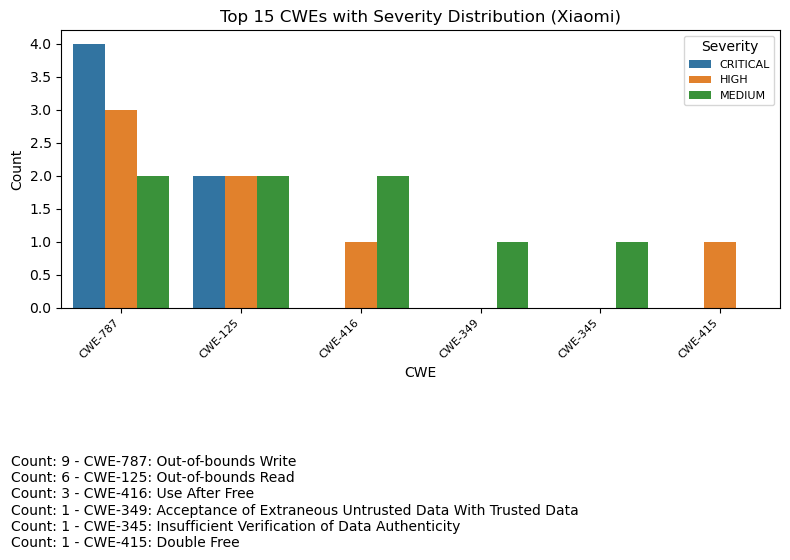

In [32]:
plot_cwe_severity_distribution(xiaomi_missing_cves_final, "Xiaomi")

## Vivo

In [33]:
vivo_security_updates = pd.read_csv('../2024_Data/vivo/vivo_security_updates.csv', encoding='utf-8')
vivo_support_lists = pd.read_csv('../2024_Data/vivo/vivo_support_lists.csv')
vivo_security_updates['device'] = vivo_security_updates['device'].str.strip()

print('Unique devices in support lists:', len(set(vivo_support_lists['device'])))
print_security_updates_statistics(vivo_security_updates, 'Vivo')

vivo_security_updates.rename(columns={'date': 'release_date'}, inplace=True)
vivo_security_updates.head()

Unique devices in support lists: 173
Vivo Statistics:
Total records: 288
Unique devices: 72


,device,firmware_filename,release_date,file_size,downloads,download_link,link,region,country,spl,post_build,android_version
0,X Fold3 Pro,PD2337F_EX_A_14.0.7.10.W30.V000L1,6/7/24,5632M,1123,https://www.vivo.com/in/support/upgradePackage...,https://www.vivo.com/in/support/system-update,in,India,5/1/24,vivo/V2330i/V2330:14/UP1A.231005.007/compiler0...,Android 14
1,Y03,PD2327F_EX_A_14.0.10.3.W20.V000L1,4/18/24,4198.4M,810,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2333/V2333:14/UP1A.231005.007/compiler03...,Android 14
2,Y100 5G,PD2341F_EX_A_14.0.8.12.W20.V000L1,4/18/24,4300.8M,430,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2327/V2327:14/UP1A.231005.007/compiler04...,Android 14
3,Y100,PD2358F_EX_A_14.0.9.4.W20.V000L1,4/18/24,4096M,140,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2342/V2342:14/UP1A.231005.007/compiler04...,Android 14
4,V30 Pro,PD2332F_EX_A_14.0.8.31.W20.V000L1,4/18/24,5120M,252,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,2/1/24,vivo/V2319/V2319:14/UP1A.231005.007/compiler02...,Android 14


In [34]:
vivo_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='vivo')
vivo_phone_data = vivo_phone_data.rename(columns={'Model': 'device'})

vivo_security_updates = map_versions(vivo_phone_data, vivo_security_updates)
device_mappings = {
    'y31（v2036）': 'Android 11',
    'y51（v2035）': 'Android 11',
    'y11(3gb)': 'Android 10',
    'y11（2gb）': 'Android 10',
    'y91c': 'Android 8.1 Oreo',
    'y85': 'Android 8.1 Oreo',
    'y11(2gb)': 'Android 10',
    'y53c': 'Android 8.1 Oreo',
    'y31l': 'Android 11',
    'v5lite': 'Android 6.0 Marshmallow',
    'y20s【g】': 'Android 10',
    'y51（8+128g）': 'Android 11',
    'y30i': 'Android 10',
    'y81d': 'Android 8.1 Oreo',
    't1pro 5g': 'Android 11',
    'v5plus': 'Android 7.1 Nougat',
    'v5 lite': 'Android 6.0 Marshmallow',
    'v1max': 'Android 5.0 Lollipop',
    'y100a': 'Android 9 Pie',
    'y15c': 'Android 9 Pie',
    'y17(4+128)': 'Android 9 Pie',
    'y66': 'Android 6.0 Marshmallow',
    'y21l': 'Android 5.1 Lollipop',
    'y51l': 'Android 11',
    'y21(2016)': 'Android 5.1 Lollipop',
    'z10': 'Android 6.0 Marshmallow',
    'y93lite': 'Android 8.1 Oreo',
    'y01': 'Android 12',  # Likely newer model, recent updates
    'y21s': 'Android 11',  # Similar to other 'y21' models
    'y33s': 'Android 12',  # Recent mid-range model
    'y21': 'Android 11',  # Similar to other 'y21' models
    'y76 5g': 'Android 12',  # Recent 5G model
    'y52': 'Android 11',  # Mid-range model
    'y72 5g': 'Android 11',  # 5G model, likely similar to y52
    'y11s': 'Android 11',  # Similar to y11 models
    'y70': 'Android 11',  # Recent mid-range model
    'y20s': 'Android 10',  # Mid-range model
    'v21 5g': 'Android 12',  # Recent 5G model
    'x60 pro': 'Android 11',  # High-end model
    'x51 5g': 'Android 11',  # 5G model, similar to x60
    'y15s': 'Android 11',  # Mid-range model
    'y51': 'Android 11',  # Recent model
    'y20': 'Android 10',  # Mid-range model
    'v21e': 'Android 12',  # Recent model
    'v21': 'Android 12',  # Recent model
    'y50': 'Android 10',  # Mid-range model
    'y52 5g': 'Android 11',  # 5G model, similar to y52
    'x50 pro': 'Android 11',  # High-end model
    'nex 3': 'Android 10',  # High-end model, older
    'y33': 'Android 12',  # Recent mid-range model
    'x70 pro +': 'Android 13',  # Latest high-end model
    'x70 pro': 'Android 13',  # Latest high-end model
    'x5pro': 'Android 9 Pie',  # Older high-end model
    'x5max': 'Android 7.1 Nougat',  # Older model
    'y75': 'Android 11',  # Mid-range model
    'y21g': 'Android 10',  # Mid-range model
    'y20t': 'Android 10',  # Mid-range model
    'y21 (2021)': 'Android 11',  # Recent model
    'v23e': 'Android 12',  # Recent model
    'v23': 'Android 12',  # Recent model
    'y02': 'Android 10',  # Mid-range model
    'y53s': 'Android 11'  # Recent model
}


for i, row in vivo_security_updates.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    if mapping:
        vivo_security_updates.at[i, 'android_version'] = mapping

vivo_security_updates.head()


Mapping versions: 100%|█████████████████████████| 3/3 [00:00<00:00, 8107.55it/s]

Devices with missing android_version:
[]


,device,firmware_filename,release_date,file_size,downloads,download_link,link,region,country,spl,post_build,android_version
0,x fold3 pro,PD2337F_EX_A_14.0.7.10.W30.V000L1,6/7/24,5632M,1123,https://www.vivo.com/in/support/upgradePackage...,https://www.vivo.com/in/support/system-update,in,India,5/1/24,vivo/V2330i/V2330:14/UP1A.231005.007/compiler0...,Android 14
1,y03,PD2327F_EX_A_14.0.10.3.W20.V000L1,4/18/24,4198.4M,810,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2333/V2333:14/UP1A.231005.007/compiler03...,Android 14
2,y100 5g,PD2341F_EX_A_14.0.8.12.W20.V000L1,4/18/24,4300.8M,430,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2327/V2327:14/UP1A.231005.007/compiler04...,Android 14
3,y100,PD2358F_EX_A_14.0.9.4.W20.V000L1,4/18/24,4096M,140,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2342/V2342:14/UP1A.231005.007/compiler04...,Android 13
4,v30 pro,PD2332F_EX_A_14.0.8.31.W20.V000L1,4/18/24,5120M,252,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,2/1/24,vivo/V2319/V2319:14/UP1A.231005.007/compiler02...,Android 14


In [35]:
# Ensure correct DataFrame name is used
vivo_security_updates = map_chipsets(vivo_phone_data, vivo_security_updates)

device_mappings = {
    'y31（v2036）': ('Qualcomm SM6115 Snapdragon 662 (11 nm)', 'qualcomm sm6115,snapdragon 662'),
    'y51（v2035）': ('Qualcomm SDM665 Snapdragon 665 (11 nm)', 'qualcomm sdm665,snapdragon 665'),
    'y11(3gb)': ('Qualcomm SDM439 Snapdragon 439 (12 nm)', 'qualcomm sdm439,snapdragon 439'),
    'y11（2gb）': ('Qualcomm SDM439 Snapdragon 439 (12 nm)', 'qualcomm sdm439,snapdragon 439'),
    'y91c': ('Mediatek MT6762 Helio P22 (12 nm)', 'mediatek mt6762'),
    'y85': ('Qualcomm MSM8953-Pro Snapdragon 626 (14 nm)', 'qualcomm msm8953,snapdragon 626'),
    'y53c': ('Qualcomm MSM8917 Snapdragon 425 (28 nm)', 'qualcomm msm8917,snapdragon 425'),
    'y31l': ('Qualcomm MSM8916 Snapdragon 410 (28 nm)', 'qualcomm msm8916,snapdragon 410'),
    'v5lite': ('Qualcomm MSM8937 Snapdragon 430 (28 nm)', 'qualcomm msm8937,snapdragon 430'),
    'y20s【g】': ('Mediatek Helio G80 (12 nm)', 'mediatek helio g80'),
    'y51（8+128g)': ('Qualcomm SDM665 Snapdragon 665 (11 nm)', 'qualcomm sdm665,snapdragon 665'),
    'y30i': ('Mediatek MT6765 Helio P35 (12 nm)', 'mediatek mt6765'),
    'y81d': ('Mediatek MT6762 Helio P22 (12 nm)', 'mediatek mt6762'),
    't1pro 5g': ('Qualcomm SM7325 Snapdragon 778G 5G (6 nm)', 'qualcomm sm7325,snapdragon 778g 5g'),
    'v5plus': ('Qualcomm MSM8953 Snapdragon 625 (14 nm)', 'qualcomm msm8953,snapdragon 625'),
    'v5 lite': ('Qualcomm MSM8937 Snapdragon 430 (28 nm)', 'qualcomm msm8937,snapdragon 430'),
    'v1max': ('Qualcomm MSM8939v2 Snapdragon 615 (28 nm)', 'qualcomm msm8939v2,snapdragon 615'),
    'y100a': ('Qualcomm MSM8916 Snapdragon 410 (28 nm)', 'qualcomm msm8916,snapdragon 410'),
    'y15c': ('Mediatek MT6765 Helio P35 (12 nm)', 'mediatek mt6765'),
    'y17(4+128)': ('Mediatek MT6765 Helio P35 (12 nm)', 'mediatek mt6765'),
    'y66': ('Qualcomm MSM8937 Snapdragon 430 (28 nm)', 'qualcomm msm8937,snapdragon 430'),
    'y21l': ('Qualcomm MSM8909 Snapdragon 210 (28 nm)', 'qualcomm msm8909,snapdragon 210'),
    'y51l': ('Qualcomm MSM8916 Snapdragon 410 (28 nm)', 'qualcomm msm8916,snapdragon 410'),
    'y21(2016)': ('Qualcomm MSM8909 Snapdragon 210 (28 nm)', 'qualcomm msm8909,snapdragon 210'),
    'z10': ('Qualcomm MSM8953 Snapdragon 625 (14 nm)', 'qualcomm msm8953,snapdragon 625'),
    'y93lite': ('Qualcomm SDM439 Snapdragon 439 (12 nm)', 'qualcomm sdm439,snapdragon 439'),
    'y01': ('Mediatek MT6765 Helio P35 (12 nm)', 'mediatek mt6765'),
    'y21s': ('Mediatek MT6769V/CU Helio G80 (12 nm)', 'mediatek mt6769v'),
    'y33s': ('Mediatek MT6769V/CU Helio G80 (12 nm)', 'mediatek mt6769v'),
    'y11(2gb)': ('Qualcomm SDM439 Snapdragon 439 (12 nm)', 'qualcomm sdm439, snapdragon 439'),
    'y51Ôºà8+128gÔºâ':('Qualcomm SDM665 Snapdragon 665 (11 nm)', 'qualcomm sdm665,snapdragon 665')
}

for i, row in vivo_security_updates.iterrows():
    device = row['device'].strip()
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):  # Direct mapping
            vivo_security_updates.at[i, 'chipset'], vivo_security_updates.at[i, 'keyword'] = mapping
        elif isinstance(mapping, dict):  # Conditional mapping
            for condition, (chipset, keyword) in mapping.items():
                if condition(row):
                    vivo_security_updates.at[i, 'chipset'], vivo_security_updates.at[i, 'keyword'] = chipset, keyword
                    break

vivo_security_updates.head()

Mapping chipsets: 100%|████████████████████████| 9/9 [00:00<00:00, 10430.71it/s]

Devices with missing chipset:
[]


,device,firmware_filename,release_date,file_size,downloads,download_link,link,region,country,spl,post_build,android_version,chipset,keyword
0,x fold3 pro,PD2337F_EX_A_14.0.7.10.W30.V000L1,6/7/24,5632M,1123,https://www.vivo.com/in/support/upgradePackage...,https://www.vivo.com/in/support/system-update,in,India,5/1/24,vivo/V2330i/V2330:14/UP1A.231005.007/compiler0...,Android 14,Qualcomm SM8650,qualcomm sm8650
1,y03,PD2327F_EX_A_14.0.10.3.W20.V000L1,4/18/24,4198.4M,810,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2333/V2333:14/UP1A.231005.007/compiler03...,Android 14,Mediatek Helio G85 (12 nm),mediatek helio g85
2,y100 5g,PD2341F_EX_A_14.0.8.12.W20.V000L1,4/18/24,4300.8M,430,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2327/V2327:14/UP1A.231005.007/compiler04...,Android 14,Mediatek Dimensity 900 (6 nm),mediatek dimensity 900
3,y100,PD2358F_EX_A_14.0.9.4.W20.V000L1,4/18/24,4096M,140,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2342/V2342:14/UP1A.231005.007/compiler04...,Android 13,Mediatek Dimensity 900 (6 nm),mediatek dimensity 900
4,v30 pro,PD2332F_EX_A_14.0.8.31.W20.V000L1,4/18/24,5120M,252,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,2/1/24,vivo/V2319/V2319:14/UP1A.231005.007/compiler02...,Android 14,Mediatek Dimensity 8200 (4 nm),mediatek dimensity 8200


In [36]:
vivo_security_updates[~vivo_security_updates['chipset'].notna()].head()

,device,firmware_filename,release_date,file_size,downloads,download_link,link,region,country,spl,post_build,android_version,chipset,keyword


In [37]:
vivo_security_updates['release_date'] = pd.to_datetime(vivo_security_updates['release_date'], errors='coerce')

vivo_security_updates['year'] = vivo_security_updates['release_date'].dt.year
vivo_security_updates['month'] = vivo_security_updates['release_date'].dt.month
vivo_security_updates['version_umbers'] = vivo_security_updates['android_version'].apply(extract_android_version)

vivo_security_updates[~vivo_security_updates['version_umbers'].isnull()].head()

/var/folders/64/c68452391mv_849dpqtr2rch0000gn/T/ipykernel_1286/4095462311.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vivo_security_updates['release_date'] = pd.to_datetime(vivo_security_updates['release_date'], errors='coerce')


,device,firmware_filename,release_date,file_size,downloads,download_link,link,region,country,spl,post_build,android_version,chipset,keyword,year,month,version_umbers
0,x fold3 pro,PD2337F_EX_A_14.0.7.10.W30.V000L1,2024-06-07,5632M,1123,https://www.vivo.com/in/support/upgradePackage...,https://www.vivo.com/in/support/system-update,in,India,5/1/24,vivo/V2330i/V2330:14/UP1A.231005.007/compiler0...,Android 14,Qualcomm SM8650,qualcomm sm8650,2024,6,14
1,y03,PD2327F_EX_A_14.0.10.3.W20.V000L1,2024-04-18,4198.4M,810,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2333/V2333:14/UP1A.231005.007/compiler03...,Android 14,Mediatek Helio G85 (12 nm),mediatek helio g85,2024,4,14
2,y100 5g,PD2341F_EX_A_14.0.8.12.W20.V000L1,2024-04-18,4300.8M,430,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2327/V2327:14/UP1A.231005.007/compiler04...,Android 14,Mediatek Dimensity 900 (6 nm),mediatek dimensity 900,2024,4,14
3,y100,PD2358F_EX_A_14.0.9.4.W20.V000L1,2024-04-18,4096M,140,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,3/1/24,vivo/V2342/V2342:14/UP1A.231005.007/compiler04...,Android 13,Mediatek Dimensity 900 (6 nm),mediatek dimensity 900,2024,4,13
4,v30 pro,PD2332F_EX_A_14.0.8.31.W20.V000L1,2024-04-18,5120M,252,https://www.vivo.com/id/support/upgradePackage...,https://www.vivo.com/id/support/system-update,id,Indonesia,2/1/24,vivo/V2319/V2319:14/UP1A.231005.007/compiler02...,Android 14,Mediatek Dimensity 8200 (4 nm),mediatek dimensity 8200,2024,4,14


In [38]:
vivo_groupby_date = group_devices(vivo_security_updates, 'vivo')
vivo_groupby_date.head()

,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2021,3,"s1, y11, v15","Android 9.0, Android 4.4","9.0, 4.4","Mediatek MT6768 Helio P65 (12 nm), Mediatek MT...","mediatek mt6768 helio p65, mediatek mt6582–ú, ...",4.4,9.0
1,2021,5,"y12, y17, v15 pro",Android 9.0,9.0,"Mediatek MT6762 Helio P22 (12 nm), Mediatek MT...","mediatek mt6762 helio p22, mediatek mt6765 hel...",9.0,9.0
2,2021,9,"y20, v21","Android 10, Android 12","10, 12","Qualcomm SM4250,Snapdragon 460 (11 nm), Mediat...","qualcomm sm4250,snapdragon 460, mediatek dimen...",10,12
3,2022,1,"y51, x70",Android 11,11,"Qualcomm SDM665,Snapdragon 665 (11 nm), Mediat...","qualcomm sdm665,snapdragon 665, mediatek dimen...",11,11
4,2022,2,v21 5g,Android 12,12,Mediatek Dimensity 800U (7 nm),mediatek dimensity 800u,12,12


In [39]:
print(len(set(cves_not_in_vivo['CVE'])))
version_ranges = cves_not_in_vivo['vul_true'].apply(find_version_range)
cves_not_in_vivo[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_vivo.index)
cves_not_in_vivo[~cves_not_in_vivo['earliest_version'].isnull()].head()

217


,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
74,2345,CVE-2023-4863,2023,10,10/5/23,NaN,A-299477569,NaN,RCE,Critical,...,REQUIRED,HIGH,HIGH,HIGH,8.8,HIGH,Out-of-bounds Write,2023-10-01,11,13


BEFORE:
Total records - Vivo: 262
Unique CVEs - Vivo: 217

AFTER:
Total records - Vivo: 262
Unique CVEs - Vivo: 217

BEFORE:
Total records - Vivo: 262
Unique CVEs - Vivo: 217

AFTER:
Total records - Vivo: 174
Unique CVEs - Vivo: 164
year
2023    73
2022    46
2024    17
2021    16
2019    11
2020    11
Name: count, dtype: int64

base_severity
HIGH        79
MEDIUM      50
CRITICAL    39
LOW          3
Name: count, dtype: int64

component
PowerVR-GPU    53
Android        30
Mali           29
Telephony       7
Kernel          6
Name: count, dtype: int64

attack_vector
LOCAL               111
NETWORK              58
ADJACENT_NETWORK      1
PHYSICAL              1
Name: count, dtype: int64

user_interaction
NONE        164
REQUIRED      7
Name: count, dtype: int64

attack_complexity
LOW     154
HIGH     17
Name: count, dtype: int64


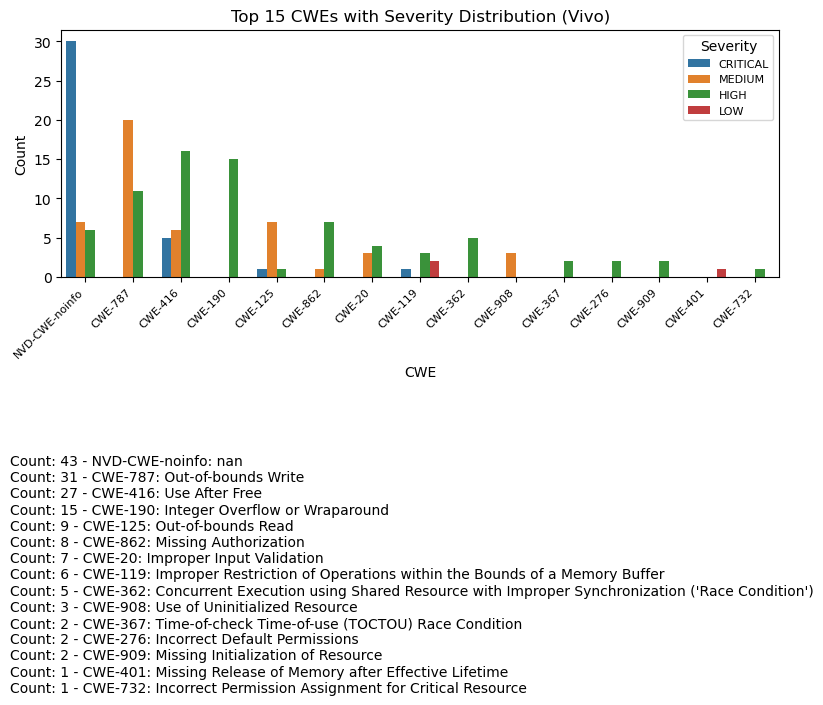

In [40]:
vivo_missing_cves = filter_cves_by_versions(cves_not_in_vivo, vivo_groupby_date, "Vivo")
print()
vivo_missing_cves_final = filter_cves_by_chipsets(vivo_missing_cves, vivo_groupby_date, 'Vivo', cve_dictionary)
cve_counts_by_year = vivo_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = vivo_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = vivo_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = vivo_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = vivo_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = vivo_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)
plot_cwe_severity_distribution(vivo_missing_cves_final, "Vivo")

## Oppo

In [41]:
oppo_support_lists = pd.read_csv('../2024_Data/oppo/oppo_support_lists.csv')
oppo_security_updates = pd.read_csv('../2024_Data/oppo/oppo_security_updates.csv')

print('Unique devices in support lists:', len(set(oppo_support_lists['model_name'])))
print_security_updates_statistics(oppo_security_updates, 'Oppo')
oppo_security_updates.rename(columns={'date': 'release_date'}, inplace=True)
oppo_security_updates.head()

Unique devices in support lists: 208
Oppo Statistics:
Total records: 18836
Unique devices: 77


,device,device_model,version,colorOS,size,release_date,downloads,download_link,region_url,search_url,android_version
0,OPPO Find X,CPH1871PUEX,CPH1871PUEX_11_F.45,11,3.41 GB,2021/10/09,"1,213",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,NaN
1,OPPO Find X,CPH1871PUEX,CPH1871PUEX_11_F.43,11,NaN,2021/08/30,965,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,NaN
2,OPPO Find X,CPH1871PUEX,CPH1871PUEX_11_F.41,11,NaN,2021/08/09,941,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,NaN
3,OPPO Find X,CPH1871PUEX,CPH1871PUEX_11_F.37,11,NaN,2021/06/09,916,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,NaN
4,OPPO Find X,CPH1871PUEX,CPH1871PUEX_11_F.35,11,NaN,2021/05/20,916,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,NaN


In [42]:
oppo_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='oppo')
oppo_phone_data = oppo_phone_data.rename(columns={'Model': 'device'})

oppo_security_updates['device'] = oppo_security_updates['device'].str.replace('OPPO', '')

In [43]:
oppo_security_updates = map_versions(oppo_phone_data, oppo_security_updates)

device_mappings = {
    'a3s(cph1853)': ('Android 8.1'),
    'a3s(cph1803)': ('Android 8.1'),
    'a83(3g+16g)(3g+32g)(4g+64g)': ('Android 7.1'),
    'a73(cph2095)': ('Android 10'),
}

for i, row in oppo_security_updates.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):
            oppo_security_updates.at[i, 'android_version'] = mapping

Mapping versions: 100%|██████████████████| 5600/5600 [00:00<00:00, 19298.04it/s]


Devices with missing android_version:
[]


In [44]:
oppo_security_updates = map_chipsets(oppo_phone_data, oppo_security_updates)

device_mappings = {
    'a3s(cph1853)': ('Qualcomm SDM450 Snapdragon 450 (14 nm)', 'qualcomm SDM450,snapdragon 450'),
    'a3s(cph1803)': ('Qualcomm SDM450 Snapdragon 450 (14 nm)', 'qualcomm SDM450,snapdragon 450'),
    'a83(3g+16g)(3g+32g)(4g+64g)': ('Mediatek MT6763T Helio P23 (16 nm)', 'mediatek mt6763t'),
    'a73(cph2095)': ('Qualcomm SM6115 Snapdragon 662 (11 nm)', 'qualcomm sm6115,snapdragon 662'),
    'find x': ('Qualcomm SDM845 Snapdragon 845 (10 nm)', 'qualcomm smd845,snapdragon 845')
}

for i, row in oppo_security_updates.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):  # Direct mapping
            oppo_security_updates.at[i, 'chipset'], oppo_security_updates.at[i, 'keyword'] = mapping
        elif isinstance(mapping, dict):  # Conditional mapping
            for condition, (chipset, keyword) in mapping.items():
                if condition(row):
                    oppo_security_updates.at[i, 'chipset'], oppo_security_updates.at[i, 'keyword'] = chipset, keyword
                    break


Mapping chipsets: 100%|██████████████████| 5822/5822 [00:00<00:00, 19261.05it/s]


Devices with missing chipset:
['a3s(cph1853)' 'a3s(cph1803)' 'a83(3g+16g)(3g+32g)(4g+64g)'
 'a73(cph2095)']


In [45]:
oppo_security_updates['release_date'] = pd.to_datetime(oppo_security_updates['release_date'], errors='coerce')

oppo_security_updates['year'] = oppo_security_updates['release_date'].dt.year
oppo_security_updates['month'] = oppo_security_updates['release_date'].dt.month
oppo_security_updates['version_umbers'] = oppo_security_updates['android_version'].apply(extract_android_version)

oppo_security_updates[~oppo_security_updates['version_umbers'].isnull()].head()

,device,device_model,version,colorOS,size,release_date,downloads,download_link,region_url,search_url,android_version,chipset,keyword,year,month,version_umbers
0,find x,CPH1871PUEX,CPH1871PUEX_11_F.45,11,3.41 GB,2021-10-09,"1,213",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,Android 10,Qualcomm SDM845 Snapdragon 845 (10 nm),"qualcomm smd845,snapdragon 845",2021.0,10.0,10
1,find x,CPH1871PUEX,CPH1871PUEX_11_F.43,11,NaN,2021-08-30,965,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,Android 10,Qualcomm SDM845 Snapdragon 845 (10 nm),"qualcomm smd845,snapdragon 845",2021.0,8.0,10
2,find x,CPH1871PUEX,CPH1871PUEX_11_F.41,11,NaN,2021-08-09,941,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,Android 10,Qualcomm SDM845 Snapdragon 845 (10 nm),"qualcomm smd845,snapdragon 845",2021.0,8.0,10
3,find x,CPH1871PUEX,CPH1871PUEX_11_F.37,11,NaN,2021-06-09,916,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,Android 10,Qualcomm SDM845 Snapdragon 845 (10 nm),"qualcomm smd845,snapdragon 845",2021.0,6.0,10
4,find x,CPH1871PUEX,CPH1871PUEX_11_F.35,11,NaN,2021-05-20,916,https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/ru/software-update/,https://support.oppo.com/ru/software-update/so...,Android 10,Qualcomm SDM845 Snapdragon 845 (10 nm),"qualcomm smd845,snapdragon 845",2021.0,5.0,10


In [46]:
oppo_groupby_date = group_devices(oppo_security_updates, 'oppo')
oppo_groupby_date.head()

,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2018.0,1.0,"f1s, f1",Android 5.1,5.1,"Mediatek MT6755 (28 nm) or MTK7650 (28 nm), Qu...","mediatek mt6755, qualcomm msm8939v2 snapdragon...",5.1,5.1
1,2018.0,3.0,"f5, f5 youth, a57, a77, r9s, f1s, f1 plus, f1,...","Android 7.1, Android 12, Android 14, Android 6...","7.1, 12, 14, 6.0, 5.1, 6","Mediatek MT6763T Helio P23 (16 nm), Mediatek D...","mediatek mt6763t helio p23, mediatek dimensity...",5.1,14
2,2018.0,4.0,"f7, a37, a71 (2018), f7 128g","Android 8.1, Android 5.1, Android 7.1","8.1, 5.1, 7.1","Mediatek MT6771 Helio P60 (12 nm), Qualcomm MS...","mediatek mt6771 helio p60, qualcomm msm8916 sn...",5.1,8.1
3,2018.0,5.0,"f5 pro, a71, f3 plus","Android 7.1, Android 6","7.1, 6","Mediatek MT6763T Helio P23 (16 nm), Mediatek M...","mediatek mt6763t helio p23, mediatek mt6750, q...",6,7.1
4,2018.0,6.0,"a71 (2018), f7 youth, f5, f5 youth","Android 7.1, Android 8.1","7.1, 8.1","Qualcomm SDM450 Snapdragon 450 (14 nm), Mediat...","qualcomm sdm450 snapdragon 450, mediatek mt677...",7.1,8.1


In [47]:
print(len(set(cves_not_in_oppo['CVE'])))
print()
version_ranges = cves_not_in_oppo['vul_true'].apply(find_version_range)
cves_not_in_oppo[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_oppo.index)
cves_not_in_oppo[~cves_not_in_oppo['earliest_version'].isnull()].head()

601



,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
0,115,CVE-2024-0015,2024,1,1/1/24,NaN,A-300090204,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,11,13
1,116,CVE-2024-0018,2024,1,1/1/24,NaN,A-300476626,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,11,14
2,117,CVE-2024-0023,2024,1,1/1/24,NaN,A-283099444,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,11,14
3,118,CVE-2024-0019,2024,1,1/1/24,NaN,A-294104969,https://android.googlesource.com/platform/fram...,ID,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,12,14
4,119,CVE-2024-0021,2024,1,1/1/24,NaN,A-282934003,https://android.googlesource.com/platform/pack...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-01,13,14


In [48]:
oppo_missing_cves = filter_cves_by_versions(cves_not_in_oppo, oppo_groupby_date, "Oppo")

BEFORE:
Total records - Oppo: 743
Unique CVEs - Oppo: 601

AFTER:
Total records - Oppo: 727
Unique CVEs - Oppo: 587


BEFORE:
Total records - Oppo: 727
Unique CVEs - Oppo: 587

AFTER:
Total records - Oppo: 714
Unique CVEs - Oppo: 577


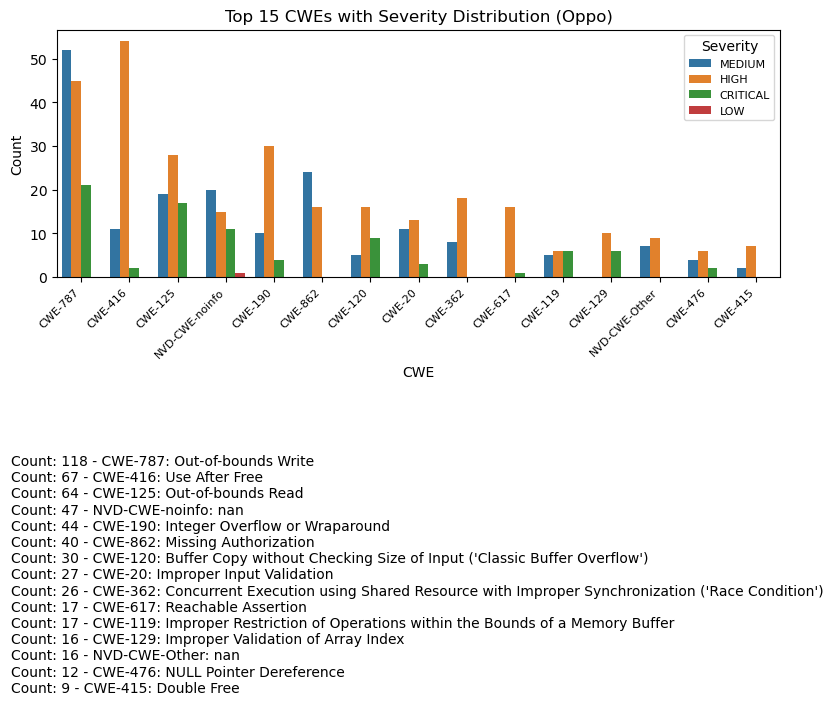

In [49]:
oppo_missing_cves_final = filter_cves_by_chipsets(oppo_missing_cves, oppo_groupby_date, 'Oppo', cve_dictionary)

plot_cwe_severity_distribution(oppo_missing_cves_final, "Oppo")

In [50]:
cve_counts_by_year = oppo_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = oppo_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = oppo_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = oppo_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = oppo_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = oppo_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

year
2021    221
2022    166
2023    107
2019     80
2024     73
2020     67
Name: count, dtype: int64

base_severity
HIGH        376
MEDIUM      226
CRITICAL     96
LOW           3
Name: count, dtype: int64

component
Closed-source component    163
Kernel                      78
Android                     47
PowerVR-GPU                 34
WLAN                        32
Name: count, dtype: int64

attack_vector
LOCAL               484
NETWORK             196
ADJACENT_NETWORK     14
PHYSICAL              7
Name: count, dtype: int64

user_interaction
NONE        643
REQUIRED     58
Name: count, dtype: int64

attack_complexity
LOW     657
HIGH     44
Name: count, dtype: int64


## Huawei

In [51]:
import pandas as pd

huawei_support_lists = pd.read_csv('../2024_Data/huawei/huawei_support_lists.csv')
print('Unique devices in support lists:', len(set(huawei_support_lists['device'])))
print_security_updates_statistics(huawei_support_lists, 'Huawei')

huawei_support_lists.head()

Unique devices in support lists: 257
Huawei Statistics:
Total records: 3037
Unique devices: 257


,timestamp,device,series,period
0,6/4/19,P30 Pro,HUAWEI P series,monthly
1,6/4/19,P30,HUAWEI P series,monthly
2,6/4/19,"P30 lite,P20 Pro",HUAWEI P series,monthly
3,6/4/19,P20,HUAWEI P series,monthly
4,6/4/19,P20 lite,HUAWEI P series,monthly


In [52]:
import numpy as np

huawei_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='huawei')
huawei_phone_data = huawei_phone_data.rename(columns={'Model': 'device'})
huawei_phone_data['OS'] = huawei_phone_data['OS'].astype(str)

huawei_support_lists = huawei_support_lists.rename(columns={'timestamp': 'release_date'})
huawei_support_lists['device'] = huawei_support_lists['device'].astype(str)
huawei_support_lists['android_version'] = np.nan

huawei_support_lists = map_versions(huawei_phone_data, huawei_support_lists)

huawei_support_lists['device'] = huawei_support_lists['device'].str.lower().str.replace('huawei', '')
huawei_support_lists['android_version'] = huawei_support_lists['android_version'].apply(process_versions)

huawei_support_lists = map_chipsets(huawei_phone_data, huawei_support_lists)
print(len(huawei_support_lists))
huawei_support_lists = huawei_support_lists.dropna(subset=['android_version'])
print(len(huawei_support_lists))

huawei_support_lists.head()

Mapping versions: 100%|███████████████████| 2012/2012 [00:00<00:00, 5495.54it/s]


Devices with missing android_version:
[]


Mapping chipsets: 100%|█████████████████████| 813/813 [00:00<00:00, 2883.98it/s]

Devices with missing chipset:
['g elite plus' 'm6(8.4" & 10.8")' 'matepad' 'huwei p smart pro'
 'nova y61']
3037
3037


,release_date,device,series,period,android_version,chipset,keyword
0,6/4/19,p30 pro,HUAWEI P series,monthly,Android 10.0,Kirin 980 (7 nm),kirin 980
1,6/4/19,p30,HUAWEI P series,monthly,Android 10.0,Kirin 980 (7 nm),kirin 980
2,6/4/19,"p30 lite,p20 pro",HUAWEI P series,monthly,Android 10.0,Kirin 980 (7 nm),kirin 980
3,6/4/19,p20,HUAWEI P series,monthly,Android 9.0,Kirin 970 (10 nm),kirin 970
4,6/4/19,p20 lite,HUAWEI P series,monthly,Android 9.0,Kirin 659 (16 nm),kirin 659


In [53]:
huawei_support_lists['release_date'] = pd.to_datetime(huawei_support_lists['release_date'], errors='coerce')

huawei_support_lists['year'] = huawei_support_lists['release_date'].dt.year
huawei_support_lists['month'] = huawei_support_lists['release_date'].dt.month
huawei_support_lists['version_umbers'] = huawei_support_lists['android_version'].apply(extract_android_version)

huawei_support_lists[~huawei_support_lists['version_umbers'].isnull()].head()
huawei_groupby_date = group_devices(huawei_support_lists, 'huawei')
huawei_groupby_date.head()

/var/folders/64/c68452391mv_849dpqtr2rch0000gn/T/ipykernel_1286/486950973.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  huawei_support_lists['release_date'] = pd.to_datetime(huawei_support_lists['release_date'], errors='coerce')


,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2019,6,"p30 pro, p30, p30 lite,p20 pro, p20, p20 lite,...","Android 10.0, Android 9.0, Android 8.0, Androi...","10.0, 9.0, 8.0, 6.0, 7.0, 8.1, 5.1","Kirin 980 (7 nm), Kirin 970 (10 nm), Kirin 659...","kirin 980, kirin 970, kirin 659, kirin 710, qu...",5.1,10.0
1,2019,7,"p30 pro, p30, p30 lite, p20 pro, p20, p20 lite...","Android 10.0, Android 9.0, Android 8.0, Androi...","10.0, 9.0, 8.0, 6.0, 7.0, 8.1, 5.1","Kirin 980 (7 nm), Kirin 710 (12 nm), Kirin 970...","kirin 980, kirin 710, kirin 970, kirin 659, qu...",5.1,10.0
2,2019,10,"p30 pro, p30, p20 pro, p20, mate 20 x, mate 20...","Android 10.0, Android 9.0, Android 8.0, Androi...","10.0, 9.0, 8.0, 8.1, 5.1, 6.0","Kirin 980 (7 nm), Kirin 970 (10 nm), Qualcomm ...","kirin 980, kirin 970, qualcomm sm8475 snapdrag...",5.1,10.0
3,2019,11,"p30 pro, p30, p20 pro, p20, mate 20 x, mate 20...","Android 10.0, Android 9.0, Android 8.0, Androi...","10.0, 9.0, 8.0, 8.1, 5.1, 6.0","Kirin 980 (7 nm), Kirin 970 (10 nm), Qualcomm ...","kirin 980, kirin 970, qualcomm sm8475 snapdrag...",5.1,10.0
4,2019,12,"p30 pro, p30, p20 pro, p20, mate 20 x, mate 20...","Android 10.0, Android 9.0, Android 8.0, Androi...","10.0, 9.0, 8.0, 8.1, 5.1, 6.0","Kirin 980 (7 nm), Kirin 970 (10 nm), Qualcomm ...","kirin 980, kirin 970, qualcomm sm8475 snapdrag...",5.1,10.0


In [54]:
print(len(set(cves_not_in_huawei['CVE'])))
print()
version_ranges = cves_not_in_huawei['vul_true'].apply(find_version_range)
cves_not_in_huawei[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_huawei.index)
cves_not_in_huawei[~cves_not_in_huawei['earliest_version'].isnull()].head()

2101



,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
0,1,CVE-2024-0029,2024,2,2/1/24,NaN,A-305664128,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-01,13,13
1,2,CVE-2024-0032,2024,2,2/1/24,NaN,A-283962634,https://android.googlesource.com/platform/pack...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-01,11,14
2,5,CVE-2024-0038,2024,2,2/1/24,NaN,A-309426390,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-01,14,14
3,6,CVE-2024-0041,2024,2,2/1/24,NaN,A-300741186,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-01,14,14
4,7,CVE-2023-40122,2024,2,2/1/24,NaN,A-286235483,https://android.googlesource.com/platform/fram...,ID,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-01,11,14


BEFORE:
Total records - huawei: 2521
Unique CVEs - huawei: 2101

AFTER:
Total records - huawei: 2461
Unique CVEs - huawei: 2049
BEFORE:
Total records - huawei: 2461
Unique CVEs - huawei: 2049

AFTER:
Total records - huawei: 2332
Unique CVEs - huawei: 1950


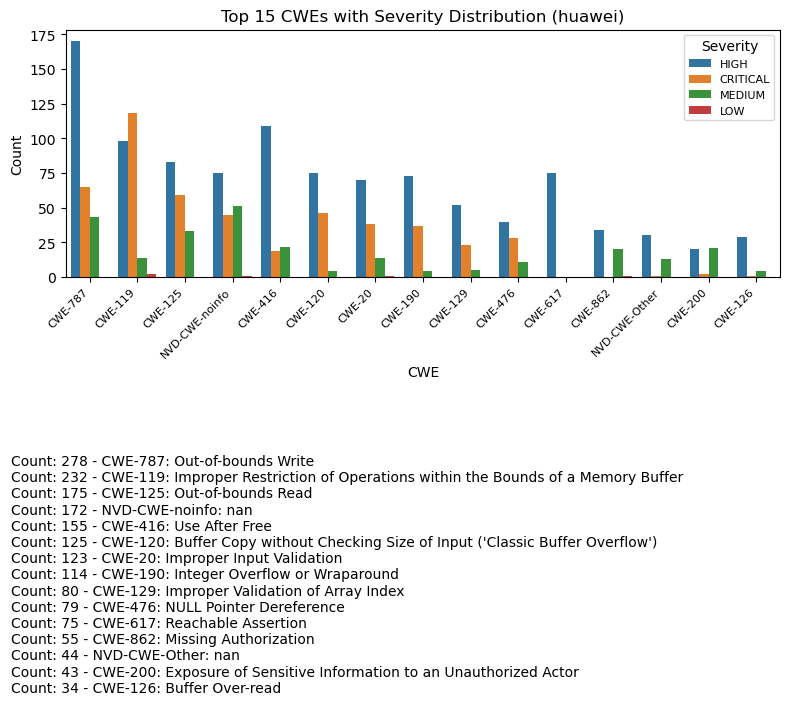

year
2018    516
2023    508
2022    314
2020    295
2021    283
2019    226
2024    190
Name: count, dtype: int64

base_severity
HIGH        1320
CRITICAL     570
MEDIUM       372
LOW           10
Name: count, dtype: int64

component
Closed-source component    1398
Kernel                       56
WLAN                         55
Mali                         47
PowerVR-GPU                  26
Name: count, dtype: int64

attack_vector
LOCAL               1243
NETWORK              957
ADJACENT_NETWORK      40
PHYSICAL              32
Name: count, dtype: int64

user_interaction
NONE        2194
REQUIRED      77
False          1
Name: count, dtype: int64

attack_complexity
LOW       2157
HIGH       114
MEDIUM       1
Name: count, dtype: int64


In [55]:
huawei_missing_cves = filter_cves_by_versions(cves_not_in_huawei, huawei_groupby_date, "huawei")
huawei_missing_cves_final = filter_cves_by_chipsets(huawei_missing_cves, huawei_groupby_date, 'huawei', cve_dictionary)

plot_cwe_severity_distribution(huawei_missing_cves_final, "huawei")
cve_counts_by_year = huawei_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = huawei_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = huawei_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = huawei_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = huawei_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = huawei_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

## LG

In [56]:
import pandas as pd

lg_security_updates = pd.read_csv('../2024_Data/lg/lg_security_updates.csv')
lg_support_lists = pd.read_csv('../2024_Data/lg/lg_support_lists.csv')
lg_support_lists = lg_support_lists.rename(columns={'model': 'device', 'date': 'release_date'})

lg_security_updates.rename(columns={'model': 'device'}, inplace=True)
print_security_updates_statistics(lg_security_updates, 'LG')
print()
print_security_updates_statistics(lg_support_lists, 'LG')

lg_support_lists.head()

LG Statistics:
Total records: 197
Unique devices: 13

LG Statistics:
Total records: 405
Unique devices: 73


,series,device,release_date
0,G series,G5,13-Dec-21
1,G series,G6,13-Dec-21
2,G series,G7,13-Dec-21
3,G series,G8,13-Dec-21
4,V series,V10,13-Dec-21


In [57]:
import numpy as np

lg_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='lg')
lg_phone_data = lg_phone_data.rename(columns={'Name': 'device'})

lg_phone_data['OS'] = lg_phone_data['OS'].astype(str)
lg_support_lists['device'] = lg_support_lists['device'].astype(str)
lg_support_lists['android_version'] = np.nan

lg_support_lists = map_versions(lg_phone_data, lg_support_lists)

device_mappings = {
    'x300': ('Android 7.0'),
    'x400': ('Android 7.0'),
    'x500': ('Android 7.0'),
    'cv3': ('Android 8.0'),
    'cv5': ('Android 8.1'),
}

for i, row in lg_support_lists.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):
            lg_support_lists.at[i, 'android_version'] = mapping

lg_support_lists['android_version'] = lg_support_lists['android_version'].apply(process_versions)

lg_support_lists = map_chipsets(lg_phone_data, lg_support_lists)

lg_support_lists.head()

Mapping versions: 100%|████████████████████| 287/287 [00:00<00:00, 12347.20it/s]


Devices with missing android_version:
[]


Mapping chipsets: 100%|████████████████████| 287/287 [00:00<00:00, 12182.75it/s]

Devices with missing chipset:
['x300' 'x400' 'x500' 'cv1' 'cv3' 'cv5' 'cv7' 'cv1s' 'cv7as' 'dh10' 'dh15'
 'dh30' 'dh35' 'dh40' 'dh5' 'dh50' 'tf10' 'eh13' 'eh35' 'style3' 'ace']


,series,device,release_date,android_version,chipset,keyword
0,G series,g5,13-Dec-21,Android 8.0,Qualcomm MSM8996 Snapdragon 820 (14 nm),qualcomm msm8996 snapdragon 820
1,G series,g6,13-Dec-21,Android 9.0,Qualcomm MSM8996 Snapdragon 821 (14 nm),qualcomm msm8996 snapdragon 821
2,G series,g7,13-Dec-21,Android 8.1,Qualcomm MSM8996 Snapdragon 821 (14 nm),qualcomm msm8996 snapdragon 821
3,G series,g8,13-Dec-21,Android 10.0,Qualcomm SM8150 Snapdragon 855 (7 nm),qualcomm sm8150 snapdragon 855
4,V series,v10,13-Dec-21,Android 5.1,Qualcomm MSM8992 Snapdragon 808 (20 nm),qualcomm msm8992 snapdragon 808


In [58]:
lg_support_lists['release_date'] = pd.to_datetime(lg_support_lists['release_date'], errors='coerce')

lg_support_lists['year'] = lg_support_lists['release_date'].dt.year
lg_support_lists['month'] = lg_support_lists['release_date'].dt.month
lg_support_lists['version_umbers'] = lg_support_lists['android_version'].apply(extract_android_version)

lg_support_lists[~lg_support_lists['version_umbers'].isnull()].head()
lg_groupby_date = group_devices(lg_support_lists, 'lg')
lg_groupby_date.head()

/var/folders/64/c68452391mv_849dpqtr2rch0000gn/T/ipykernel_1286/62995296.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lg_support_lists['release_date'] = pd.to_datetime(lg_support_lists['release_date'], errors='coerce')


,year,month,device,android_version,version_umbers,chipset,keyword,earliest_version,latest_version
0,2021,12,"g5, g6, g7, g8, v10, v20, v30, v35, v40, v50, ...","Android 8.0, Android 9.0, Android 8.1, Android...","8.0, 9.0, 8.1, 10.0, 5.1, 11.0, 6.0","Qualcomm MSM8996 Snapdragon 820 (14 nm), Qualc...","qualcomm msm8996 snapdragon 820, qualcomm msm8...",5.1,11.0
1,2022,1,"g5, g6, g7, g8, v10, v20, v30, v35, v40, v50, ...","Android 8.0, Android 9.0, Android 8.1, Android...","8.0, 9.0, 8.1, 10.0, 5.1, 11.0, 6.0","Qualcomm MSM8996 Snapdragon 820 (14 nm), Qualc...","qualcomm msm8996 snapdragon 820, qualcomm msm8...",5.1,11.0
2,2022,3,"g5, g6, g7, g8, v10, v20, v30, v35, v40, v50, ...","Android 8.0, Android 9.0, Android 8.1, Android...","8.0, 9.0, 8.1, 10.0, 5.1, 11.0, 6.0","Qualcomm MSM8996 Snapdragon 820 (14 nm), Qualc...","qualcomm msm8996 snapdragon 820, qualcomm msm8...",5.1,11.0
3,2022,5,"g5, g6, g7, g8, v10, v20, v30, v35, v40, v50, ...","Android 8.0, Android 9.0, Android 8.1, Android...","8.0, 9.0, 8.1, 10.0, 5.1, 11.0, 6.0","Qualcomm MSM8996 Snapdragon 820 (14 nm), Qualc...","qualcomm msm8996 snapdragon 820, qualcomm msm8...",5.1,11.0
4,2022,6,"g5, g6, g7, g8, v10, v20, v30, v35, v40, v50, ...","Android 8.0, Android 9.0, Android 8.1, Android...","8.0, 9.0, 8.1, 10.0, 5.1, 11.0, 6.0","Qualcomm MSM8996 Snapdragon 820 (14 nm), Qualc...","qualcomm msm8996 snapdragon 820, qualcomm msm8...",5.1,11.0


In [59]:
print(len(set(cves_not_in_lg['CVE'])))
print()
version_ranges = cves_not_in_lg['vul_true'].apply(find_version_range)
cves_not_in_lg[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_lg.index)
cves_not_in_lg[~cves_not_in_lg['earliest_version'].isnull()].head()

780



,ID,CVE,year,month,spl_type,date,bug,link,Type,Severity,...,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Date,earliest_version,latest_version
1,912,CVE-2018-9468,2018,9,9/5/18,NaN,A-111084083,https://android.googlesource.com/platform/pack...,ID,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-01,7.0,9
9,3677,CVE-2021-39673,2022,10,10/1/22,NaN,A-195410559,https://android.googlesource.com/platform/pack...,ID,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-01,13,13
10,3714,CVE-2022-2209,2022,11,11/1/22,NaN,A-235601882,https://android.googlesource.com/platform/fram...,EoP,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-01,10,13
291,722,CVE-2018-9459,2018,8,8/1/18,NaN,A-66230183,https://android.googlesource.com/platform/pack...,EoP,High,...,REQUIRED,HIGH,HIGH,HIGH,8.8,HIGH,Improper Limitation of a Pathname to a Restric...,2018-08-01,6.0,8.1
316,979,CVE-2019-2222,2019,12,12/1/19,NaN,A-140322595,https://android.googlesource.com/platform/exte...,"RCE, RCE","Moderate, Critical",...,REQUIRED,HIGH,HIGH,HIGH,7.8,HIGH,Out-of-bounds Write,2019-12-01,10,10


BEFORE:
Total records - LG: 854
Unique CVEs - LG: 780

AFTER:
Total records - LG: 854
Unique CVEs - LG: 780
BEFORE:
Total records - LG: 854
Unique CVEs - LG: 780

AFTER:
Total records - LG: 854
Unique CVEs - LG: 780


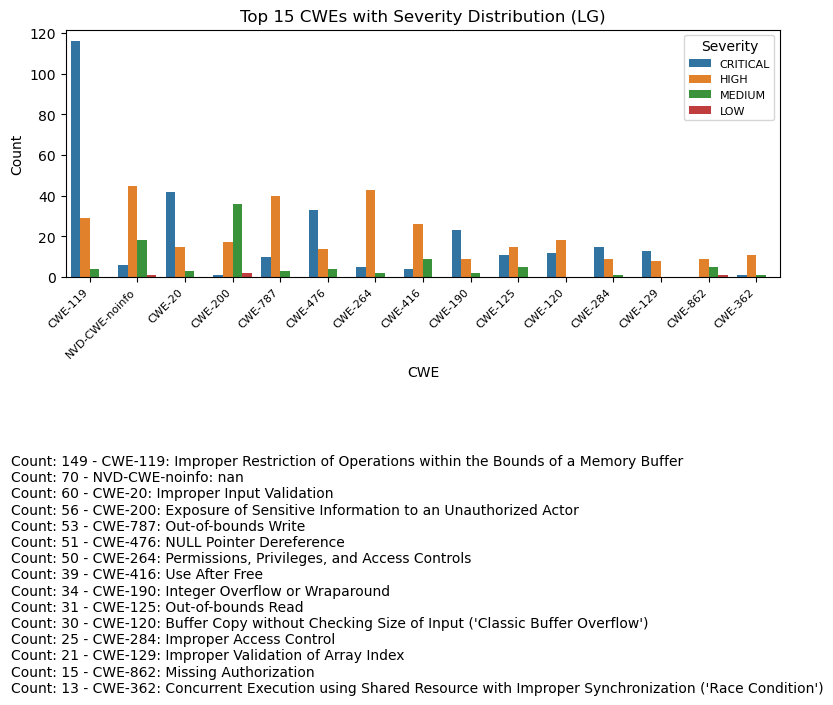

year
2018    309
2017    207
2022     85
2020     83
2016     56
2021     46
2019     42
2023     26
Name: count, dtype: int64

base_severity
HIGH        382
CRITICAL    323
MEDIUM      131
LOW           5
Name: count, dtype: int64

component
Closed-source component    454
WLAN                        12
Kernel                       9
Android                      6
Sound driver                 6
Name: count, dtype: int64

attack_vector
NETWORK             443
LOCAL               359
ADJACENT_NETWORK     30
PHYSICAL              9
Name: count, dtype: int64

user_interaction
NONE        650
REQUIRED    189
False         2
Name: count, dtype: int64

attack_complexity
LOW     735
HIGH    106
Name: count, dtype: int64


In [60]:
lg_missing_cves = filter_cves_by_versions(cves_not_in_lg, lg_groupby_date, "LG")
lg_missing_cves_final = filter_cves_by_chipsets(lg_missing_cves, lg_groupby_date, 'LG', cve_dictionary)

plot_cwe_severity_distribution(lg_missing_cves_final, "LG")
cve_counts_by_year = lg_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = lg_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = lg_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = lg_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = lg_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = lg_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

## Motorola

In [61]:
import pandas as pd

motorola_support_lists = pd.read_csv('../2024_Data/motorola/motorola_support_lists.csv')
print_security_updates_statistics(motorola_support_lists, 'Motorola')
motorola_support_lists.head()

Motorola Statistics:
Total records: 488
Unique devices: 19


,device_family,device,country,date,security_type,launch_date,support_end_date,launch_OS,upgraded_to_OS,next_OS,note1,note2,link
0,android one family,moto g pro,Australia,20230510,monthly,"june, 2020","june, 2023",NaN,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...
1,moto g family,1 device,Australia,20230510,regular,"april, 2023","april, 2026",android 13,NaN,android 14,this device will receive at least bimonthly sm...,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...
2,moto e family,moto e40,Australia,20230510,regular,"september, 2021","september, 2023",NaN,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...
3,motorola edge family,1 device,Australia,20230510,regular,"may, 2023","may, 2027",android 13,NaN,android 14,this device will receive at least bimonthly sm...,NaN,https://web.archive.org/web/20230510/https://e...
4,motorola one family,motorola one 5G UW ACE,Australia,20230510,regular,"july, 2021","july, 2023",NaN,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...


In [62]:
import numpy as np

motorola_phone_data = pd.read_excel('../2024_Data/phone_data_all.xlsx', sheet_name='motorola')
motorola_phone_data = motorola_phone_data.rename(columns={'Name': 'device'})

motorola_support_lists = motorola_support_lists.rename(columns={'date': 'release_date', 'launch_OS': 'android_version'})

motorola_phone_data['OS'] = motorola_phone_data['OS'].astype(str)
motorola_support_lists['device'] = motorola_support_lists['device'].str.lower().str.replace('motorola', '')
motorola_support_lists['device'] = motorola_support_lists['device'].astype(str)

motorola_support_lists = map_versions(motorola_phone_data, motorola_support_lists)

device_mappings = {
    'x300': ('Android 7.0'),
    'x400': ('Android 7.0'),
    'x500': ('Android 7.0'),
    'cv3': ('Android 8.0'),
    'cv5': ('Android 8.1'),
}

for i, row in motorola_support_lists.iterrows():
    device = row['device']
    mapping = device_mappings.get(device)
    
    if mapping:
        if isinstance(mapping, tuple):
            motorola_support_lists.at[i, 'android_version'] = mapping

motorola_support_lists['android_version'] = motorola_support_lists['android_version'].apply(process_versions)

motorola_support_lists = map_chipsets(motorola_phone_data, motorola_support_lists)
motorola_support_lists.head()

Mapping versions: 100%|█████████████████████| 113/113 [00:00<00:00, 2352.49it/s]


Devices with missing android_version:
[]


Mapping chipsets: 100%|█████████████████████| 248/248 [00:00<00:00, 2164.30it/s]

Devices with missing chipset:
['1 device']


,device_family,device,country,release_date,security_type,launch_date,support_end_date,android_version,upgraded_to_OS,next_OS,note1,note2,link,chipset,keyword
0,android one family,moto g pro,Australia,20230510,monthly,"june, 2020","june, 2023",Android 12.0,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...,Qualcomm SDM665 Snapdragon 665 (11 nm),qualcomm sdm665 snapdragon 665
1,moto g family,1 device,Australia,20230510,regular,"april, 2023","april, 2026",android 13.0,NaN,android 14,this device will receive at least bimonthly sm...,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...,NaN,
2,moto e family,moto e40,Australia,20230510,regular,"september, 2021","september, 2023",Android 11.0,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...,Unisoc T700,unisoc t700
3,motorola edge family,1 device,Australia,20230510,regular,"may, 2023","may, 2027",android 13.0,NaN,android 14,this device will receive at least bimonthly sm...,NaN,https://web.archive.org/web/20230510/https://e...,NaN,
4,motorola one family,one 5g uw ace,Australia,20230510,regular,"july, 2021","july, 2023",Android 11.0,NaN,NaN,NaN,channels and regions may have different launch...,https://web.archive.org/web/20230510/https://e...,Qualcomm SM7225 Snapdragon 750G 5G (8 nm),qualcomm sm7225 snapdragon 750g 5g


In [63]:
motorola_support_lists['release_date'] = pd.to_datetime(motorola_support_lists['release_date'], errors='coerce')

motorola_support_lists['year'] = motorola_support_lists['release_date'].dt.year
motorola_support_lists['month'] = motorola_support_lists['release_date'].dt.month
motorola_support_lists['version_umbers'] = motorola_support_lists['android_version'].apply(extract_android_version)

motorola_support_lists[~motorola_support_lists['version_umbers'].isnull()].head()
motorola_groupby_date = group_devices(motorola_support_lists, 'motorola')
motorola_groupby_date.head()
print(len(set(cves_not_in_motorola['CVE'])))
print()
version_ranges = cves_not_in_motorola['vul_true'].apply(find_version_range)
cves_not_in_motorola[['earliest_version', 'latest_version']] = pd.DataFrame(version_ranges.tolist(), index=cves_not_in_motorola.index)
cves_not_in_motorola[~cves_not_in_motorola['earliest_version'].isnull()].head()
motorola_missing_cves = filter_cves_by_versions(cves_not_in_motorola, motorola_groupby_date, "Motorola")
motorola_missing_cves_final = filter_cves_by_chipsets(motorola_missing_cves, motorola_groupby_date, 'Motorola', cve_dictionary)

94

BEFORE:
Total records - Motorola: 108
Unique CVEs - Motorola: 94

AFTER:
Total records - Motorola: 108
Unique CVEs - Motorola: 94
BEFORE:
Total records - Motorola: 108
Unique CVEs - Motorola: 94

AFTER:
Total records - Motorola: 108
Unique CVEs - Motorola: 94


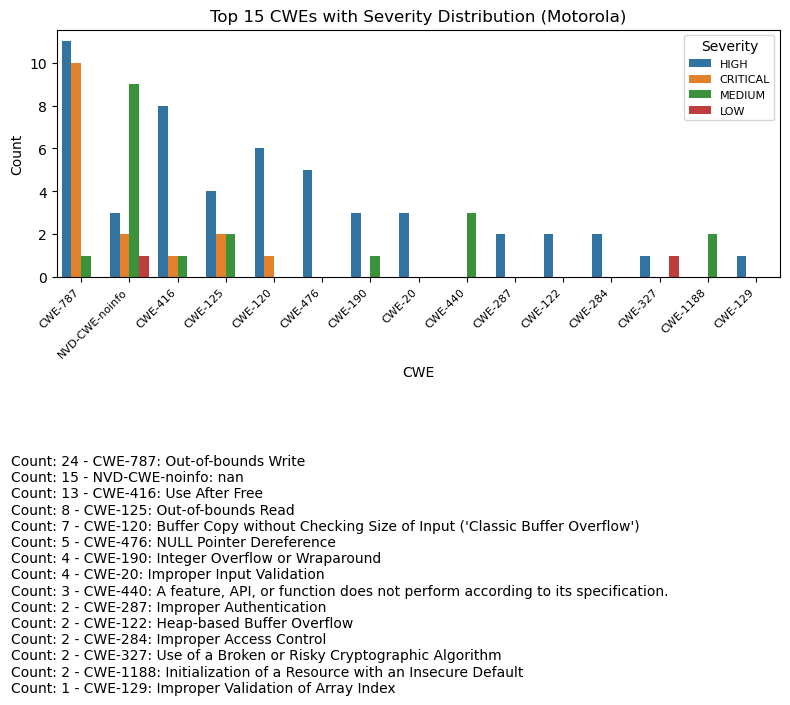

year
2020    45
2021    34
2024    19
2023     7
2022     3
Name: count, dtype: int64

base_severity
HIGH        62
MEDIUM      21
CRITICAL    16
LOW          2
Name: count, dtype: int64

component
Closed-source component    36
vcu                         4
Broadcom Firmware           4
WLAN                        4
FPC Iris TZ App             3
Name: count, dtype: int64

attack_vector
LOCAL               68
NETWORK             25
ADJACENT_NETWORK     7
PHYSICAL             1
Name: count, dtype: int64

user_interaction
NONE        99
REQUIRED     2
Name: count, dtype: int64

attack_complexity
LOW     99
HIGH     2
Name: count, dtype: int64


In [64]:
plot_cwe_severity_distribution(motorola_missing_cves_final, "Motorola")
cve_counts_by_year = motorola_missing_cves_final['year'].value_counts()
print(cve_counts_by_year)
print()
base_severity_by_year = motorola_missing_cves_final['base_severity'].value_counts()
print(base_severity_by_year)
print()
top_component = motorola_missing_cves_final['component'].value_counts().head(5)
print(top_component)
print()
attack_vector = motorola_missing_cves_final['attack_vector'].value_counts()
print(attack_vector)
print()
user_interaction = motorola_missing_cves_final['user_interaction'].value_counts()
print(user_interaction)
print()
attack_complexity = motorola_missing_cves_final['attack_complexity'].value_counts()
print(attack_complexity)

# All

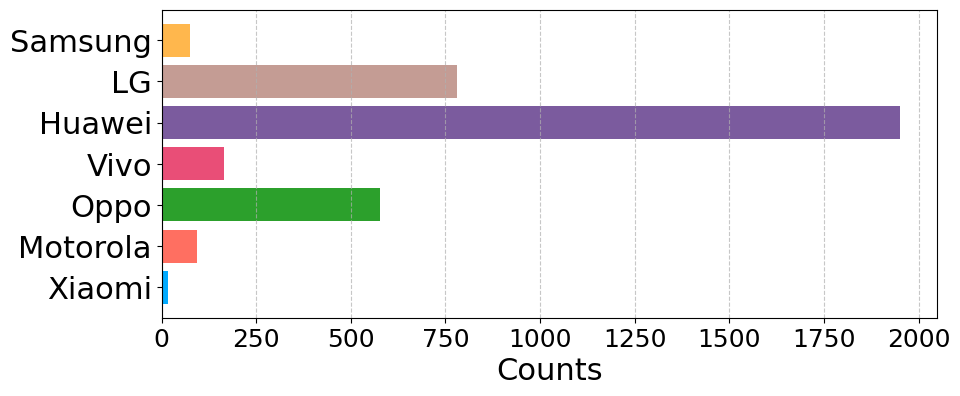

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from the data
date_columns = {
    'Xiaomi': len(xiaomi_missing_cves_final['CVE'].unique()),
    'Motorola': len(motorola_missing_cves_final['CVE'].unique()),
    'Oppo': len(oppo_missing_cves_final['CVE'].unique()),
    'Vivo': len(vivo_missing_cves_final['CVE'].unique()),
    'Huawei': len(huawei_missing_cves_final['CVE'].unique()),
    'LG': len(lg_missing_cves_final['CVE'].unique()),
    'Samsung': len(samsung_missing_cves_final['CVE'].unique()),
}

data = [{'OEM': oem, 'Count': count} for oem, count in date_columns.items()]
df_all = pd.DataFrame(data)

# Define a color for each OEM
colors = ['#00aaff', '#ff6f61', '#2ca02c', '#e94e77', '#7b5b9e', '#c49c94', '#ffb74d']

# Plot the data
plt.figure(figsize=(10, 4))
plt.barh(df_all['OEM'], df_all['Count'], color=colors)
plt.xlabel('Counts', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=22)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('../2024_Data/Figures/all_missing_cves.png', bbox_inches='tight')
plt.show()


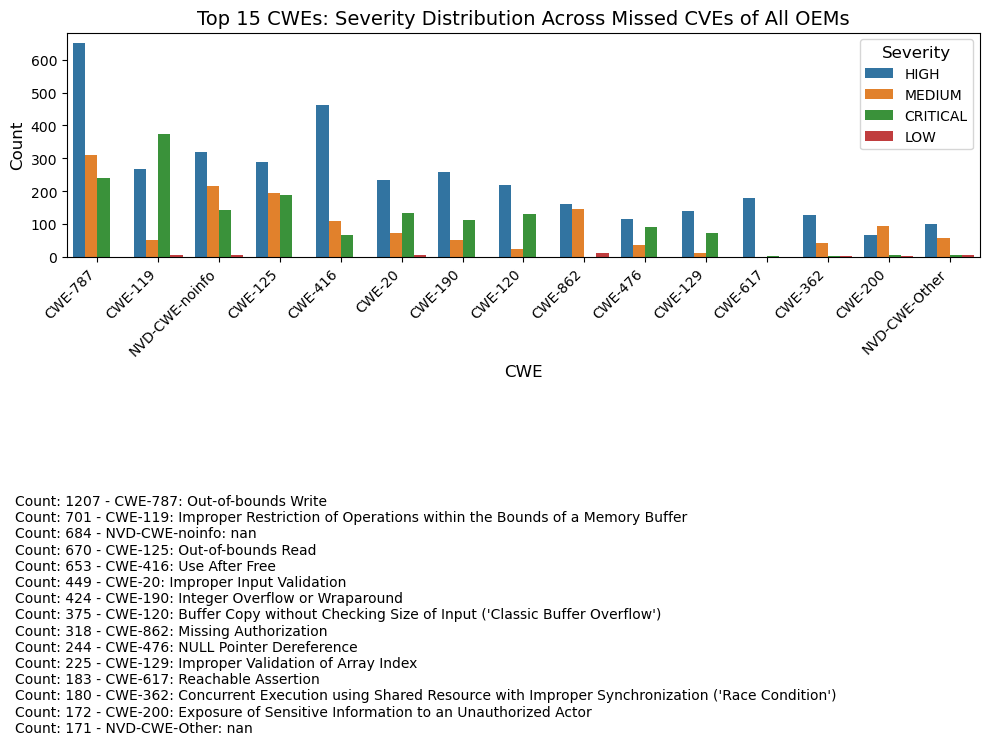

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data and calculate missing CVEs
def calculate_missing_cves():
    oem_data_files = {
        'Xiaomi': '../2024_Data/xiaomi/ASB_only_cves.csv',
        'Motorola': '../2024_Data/motorola/ASB_only_cves.csv',
        'Oppo': '../2024_Data/oppo/ASB_only_cves.csv',
        'Vivo': '../2024_Data/vivo/ASB_only_cves.csv',
        'Huawei': '../2024_Data/huawei/ASB_only_cves.csv',
        'Pixel': '../2024_Data/pixel/ASB_only_cves.csv',
        'LG': '../2024_Data/lg/ASB_only_cves.csv',
        'Samsung': '../2024_Data/samsung/missing_cves.csv'
    }

    data_columns = {}
    oem_dataframes = {}

    for oem, file in oem_data_files.items():
        df = pd.read_csv(file)
        oem_dataframes[oem] = df
        data_columns[oem] = len(set(df['CVE']))

    return data_columns, oem_dataframes

# Function to plot number of missing CVEs
def plot_missing_cves(data_columns):
    plt.figure(figsize=(10, 4))
    plt.barh(list(data_columns.keys()), list(data_columns.values()), color='skyblue')
    plt.xlabel('Counts', fontsize=10)
    plt.ylabel('OEMs', fontsize=10)
    plt.title('Number of Missing CVEs of OEMs')
    plt.grid(axis='x')
    plt.savefig("../2024_Data/Figures/num_missing_cves.png", bbox_inches="tight")
    plt.show()

# Function to plot top CWEs with severity distribution across all OEMs
def plot_combined_cwe_severity_distribution(oem_dataframes):
    combined_data = pd.concat(oem_dataframes.values(), ignore_index=True)
    top_cwes = combined_data['cwe'].value_counts().head(15)

    severity_data = []
    for cwe, count in top_cwes.items():
        severity_counts = combined_data[combined_data['cwe'] == cwe]['base_severity'].value_counts().reset_index()
        severity_counts.columns = ['severity', 'count']
        severity_counts['cwe'] = cwe
        severity_data.append(severity_counts)

    severity_df = pd.concat(severity_data, ignore_index=True)

    plt.figure(figsize=(10, 4))
    sns.barplot(x='cwe', y='count', hue='severity', data=severity_df)
    plt.title('Top 15 CWEs: Severity Distribution Across Missed CVEs of All OEMs', fontsize=14)
    plt.xlabel('CWE', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Severity', loc='upper right', title_fontsize=12, fontsize=10)
    plt.tight_layout()

    # Extract cwe_info for CWEs in the chart
    unique_cwes = top_cwes.index
    cwe_info_texts = [f"Count: {combined_data['cwe'].value_counts()[cwe]} - {cwe}: {combined_data[combined_data['cwe'] == cwe]['cwe_info'].iloc[0]}" for cwe in unique_cwes]
    cwe_info_text = "\n".join(cwe_info_texts)

    # Add the cwe_info text at the bottom of the plot
    plt.gcf().text(0.02, -0.25, cwe_info_text, fontsize=10, ha='left', va='top')

    # Save the plot as an image file
    plt.savefig("../2024_Data/Figures/combined_severity_distribution.png", bbox_inches="tight")
    plt.show()


data_columns, oem_dataframes = calculate_missing_cves()
# plot_missing_cves(data_columns)

plot_combined_cwe_severity_distribution(oem_dataframes)